# Complexity and Similarity

## Preparation

### Required Libraries

In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
import seaborn as sns

import textstat
from lexicalrichness import LexicalRichness
import spacy
# !python -m spacy download en_core_web_md # <--- download spacy english core web medium model
nlp = spacy.load('en_core_web_md') # Load the spaCy medium model with GloVe300 vectors

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm
# from tqdm.notebook import tqdm_notebook
sns.reset_orig() # reset sns theme

import pickle
import warnings
warnings.filterwarnings('ignore') # <--- comment-out this line if you are running this notebook for the first time 

### Import data and conduct necessary checks

In [2]:
# load preprocessed and normalised data 
df_review_norm = pd.read_csv("review_camera_normalised.csv")
df_review_norm.dropna(subset=['reviewText'], inplace=True)
df_review_all_cat_subset_norm = pd.read_csv("review_subset_normalised.csv")
df_review_all_cat_subset_norm.dropna(subset=['reviewText'], inplace=True)

In [3]:
df_review_all_cat_subset_norm = df_review_all_cat_subset_norm.sample(frac=0.5, random_state=9)
df_review_all_cat_subset_norm = df_review_all_cat_subset_norm[['overall', 'reviewText', 'Year']]
df_review_all_cat_subset_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2046440 entries, 2787446 to 4060023
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   reviewText  object 
 2   Year        int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 62.5+ MB


In [4]:
df_review_norm = df_review_norm[['overall', 'reviewText', 'Year']]
df_review_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2491094 entries, 0 to 2502222
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   reviewText  object 
 2   Year        int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 76.0+ MB


## Similarity analysis

Bag of Word Similarity:
- the similarity is computed by: 
    - Use unigram TF-IDF to vectorise review text to obtain Document Feature Matrix
    - Average TF-IDF score of each word to obtain One-Dimension yearly word representation 
    - Compute Cosine Similarity
    

GloVe Embedding Similarity: 
- the similarity is computed by: 
    - Obtain GloVe-300 embedding of each word in each review 
    - Average embedding dimension to obtain One-Dimension yearly representation
    - Compute Cosine Similarity
    - __Note: we choose to vectorise review with a static word embedding `GloVe` (since review sentences were object-normalised, context-dependent embeddings, such as `BERT` and `GPT-3` were not used) to obtain construct GloVe__

In [6]:
# function to calculate the average yearly BoW cosine similarity of the reviews
def dfm_yearly_sim_avg(df, start_year, end_year, vectorizer_type):
    vectorizer = vectorizer_type(ngram_range=(1, 1))
    years = range(start_year, end_year + 1)
    
    dfm_by_year_avg_t = {}
    
    for year in tqdm(years, leave = False):
        yearly_reviews = df[df['Year'] == year]['reviewText']
        dfm = vectorizer.fit_transform(yearly_reviews)
        dfm = dfm.astype(np.float32) # drop precision to save memory 
        dfm_dense = dfm.todense()
        feature_names = vectorizer.get_feature_names_out()
        dfm_df = pd.DataFrame(dfm_dense, columns=feature_names)
        dfm_by_year_avg_t[year] = dfm_df.mean(axis=0)

    avg_df = pd.DataFrame.from_dict(dfm_by_year_avg_t)
    avg_df.fillna(0, inplace=True)
    
    return avg_df.T

In [7]:
# function to calculate the average yearly GloVe similarity of the reviews
def spacy_glove_300_yearly_sim_avg(df, start_year, end_year, batch_size=5000, n_process=-1):
    years = range(start_year, end_year + 1)
    dfm_by_year_avg = {}

    for year in tqdm(years, desc="Processing years", leave = False):
        yearly_reviews = df[df['Year'] == year]['reviewText']
        yearly_vectors = []

        for docs in tqdm(nlp.pipe(yearly_reviews, batch_size=batch_size, 
                                                disable=["parser", "ner"],
                                                n_process=n_process,), 
                                    total=len(yearly_reviews), leave = False,
                                    desc=f"Processing reviews for {year}"):
            for doc in docs:
                vectors = doc.vector # doc.vector - get the average vector representation for the entire review
                yearly_vectors.append(vectors)

        dfm_by_year_avg[year] = np.mean(yearly_vectors, axis=0) if yearly_vectors else np.zeros((300,))  # glove size 300

    avg_df = pd.DataFrame.from_dict(dfm_by_year_avg)
    return avg_df.T

In [92]:
# define a function to save the model object as a pickle file for future use
def save_as_pickle(obj, obj_name):
    filename = f'{obj_name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        print(f"Object saved as {filename}")

### Review similarity by year

#### Bag of Words Similarity

##### Bag of words similarity of all ratings (1-5)

In [8]:
# warning: depending on your environment, you need at least 96+ GB of memory to run this function (this can be either physical or virtual memory)
# virtual memory is usually pre-defined by your OS, please adjust memory size if necessary
bow_yearly_avg_all_ratings = dfm_yearly_sim_avg(df=df_review_norm, start_year=1999, end_year=2018, vectorizer_type=TfidfVectorizer)
bow_yearly_avg_all_ratings

aa       aaa          aaaa     aaaaa    aaaaaa   aaaaaaa  \
1999  0.004255  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2000  0.004514  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2001  0.005188  0.000038  0.000000e+00  0.000000  0.000000  0.000000   
2002  0.005324  0.000070  0.000000e+00  0.000000  0.000000  0.000000   
2003  0.006800  0.000378  0.000000e+00  0.000000  0.000000  0.000000   
2004  0.006527  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2005  0.005699  0.000107  0.000000e+00  0.000000  0.000000  0.000000   
2006  0.004455  0.000066  0.000000e+00  0.000000  0.000000  0.000000   
2007  0.003840  0.000052  0.000000e+00  0.000000  0.000000  0.000000   
2008  0.003367  0.000030  0.000000e+00  0.000000  0.000000  0.000000   
2009  0.003155  0.000036  0.000000e+00  0.000000  0.000000  0.000000   
2010  0.002731  0.000053  5.453543e-06  0.000000  0.000000  0.000000   
2011  0.002265  0.000053  0.000000e+00  0.000000  0.000000  0.000000   
2012  0.001718  0.000071  5.972971e-07  0.000000  0.000000  0.000000   
2013  0.001315  0.000054  4.560635e-06  0.000001  0.000003  0.000001   
2014  0.000909  0.000039  1.155749e-05  0.000020  0.000000  0.000000   
2015  0.000650  0.000041  8.611243e-06  0.000002  0.000002  0.000000   
2016  0.000508  0.000037  1.665050e-05  0.000000  0.000002  0.000000   
2017  0.000414  0.000047  6.490246e-06  0.000003  0.000000  0.000001   
2018  0.000437  0.000029  1.180453e-05  0.000000  0.000000  0.000000   

      aaaaaaaa  aaaaaaaaaa  aaaaaaaaaaa  aaaaaaaaaaaaa  ...          zzzz  \
1999  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2000  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2001  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2002  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2003  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2004  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2005  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2006  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2007  0.000000    0.000013     0.000000       0.000000  ...  0.000000e+00   
2008  0.000000    0.000000     0.000000       0.000000  ...  7.329995e-07   
2009  0.000000    0.000000     0.000000       0.000000  ...  2.625085e-06   
2010  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2011  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2012  0.000000    0.000000     0.000000       0.000003  ...  0.000000e+00   
2013  0.000000    0.000001     0.000000       0.000000  ...  0.000000e+00   
2014  0.000002    0.000000     0.000003       0.000000  ...  0.000000e+00   
2015  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2016  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   
2017  0.000003    0.000000     0.000000       0.000000  ...  0.000000e+00   
2018  0.000000    0.000000     0.000000       0.000000  ...  0.000000e+00   

             zzzzz  zzzzzoop    zzzzzz       zzzzzzz  zzzzzzzzip  zzzzzzzzz  \
1999  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2000  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2001  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2002  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2003  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2004  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2005  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2006  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2007  0.000000e+00  0.000000  0.000000  0.000000e+00    0.000000   0.000000   
2008  0.000000e+00  0.000000  0.000008  0.000000e+00    0.000000   0.000000   
2009  0.0000

In [88]:
cosine_sim_matrix_bow_1_5 = cosine_similarity(bow_yearly_avg_all_ratings)

In [101]:
save_as_pickle(bow_yearly_avg_all_ratings, "bow_yearly_avg_all_ratings")
save_as_pickle(cosine_sim_matrix_bow_1_5, "cosine_sim_matrix_bow_1_5")

Object saved as bow_yearly_avg_all_ratings.pkl
Object saved as cosine_sim_matrix_bow_1_5.pkl


In [ ]:
file_path = "cosine_sim_matrix_bow_1_5.pickle"

with open(file_path, "wb") as file:
    pickle.dump(cosine_sim_matrix_bow_1_5, file)
cosine_sim_matrix_bow_1_5 

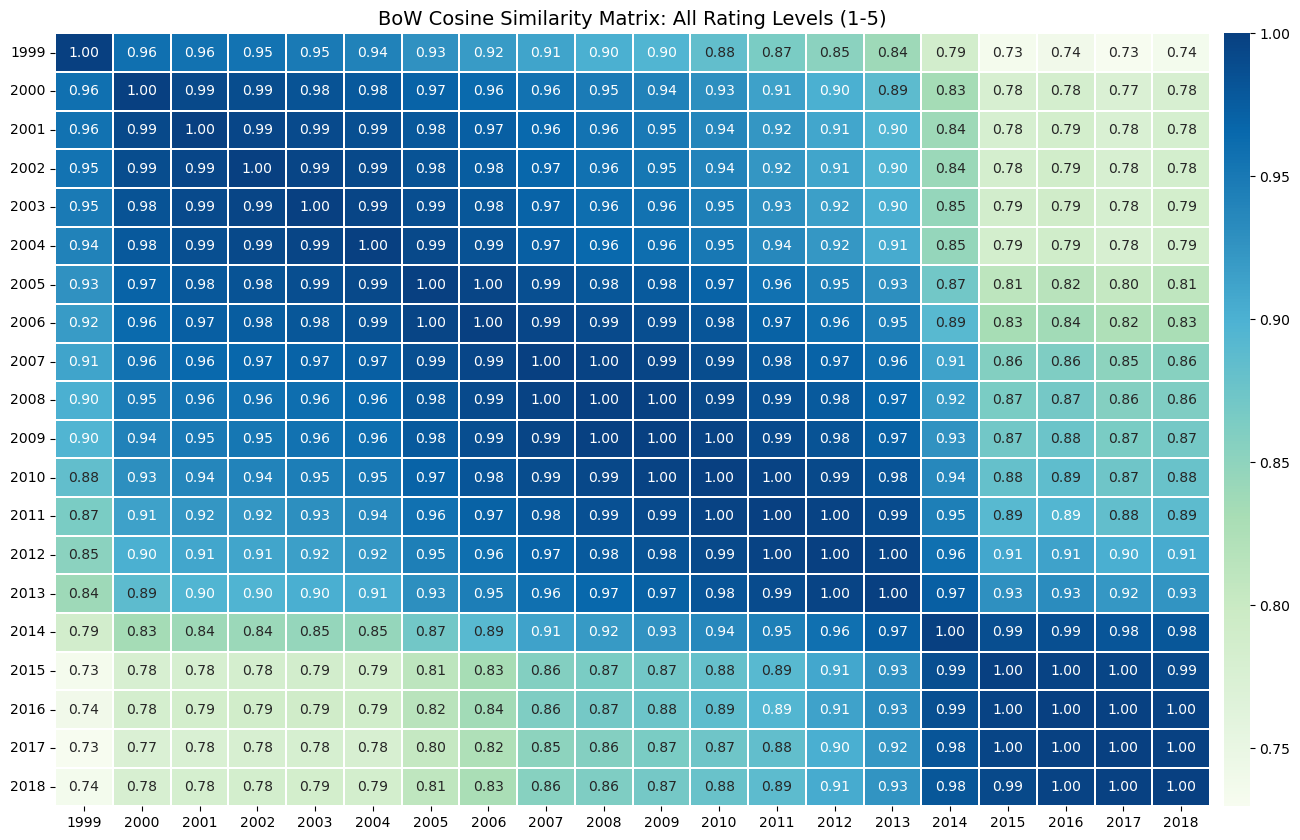

In [99]:
plt.figure(figsize=(14.5, 8.5))
heatmap = sns.heatmap(
    cosine_sim_matrix_bow_1_5,
    annot=True,
    cmap="GnBu",
    fmt=".2f",
    xticklabels=bow_yearly_avg_all_ratings.index,
    yticklabels=bow_yearly_avg_all_ratings.index,
    cbar_kws={"shrink": 1, "aspect": 30, "pad": 0.01},
    linewidths=0.01,
    linecolor='white'  
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=0, horizontalalignment="center"
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title("BoW Cosine Similarity Matrix: All Rating Levels (1-5)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

##### Bag of words similarity of rating = 5

In [11]:
rating = 5

In [12]:
bow_yearly_average_rating_5 = dfm_yearly_sim_avg(df=df_review_norm[df_review_norm["overall"] == rating], start_year=1999, end_year=2018, vectorizer_type=TfidfVectorizer)
bow_yearly_average_rating_5

aa       aaa          aaaa     aaaaa    aaaaaa   aaaaaaa  \
1999  0.002887  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2000  0.004913  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2001  0.005451  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2002  0.005516  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2003  0.006478  0.000250  0.000000e+00  0.000000  0.000000  0.000000   
2004  0.006963  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2005  0.006172  0.000102  0.000000e+00  0.000000  0.000000  0.000000   
2006  0.004885  0.000065  0.000000e+00  0.000000  0.000000  0.000000   
2007  0.003905  0.000051  0.000000e+00  0.000000  0.000000  0.000000   
2008  0.003266  0.000029  0.000000e+00  0.000000  0.000000  0.000000   
2009  0.003294  0.000030  0.000000e+00  0.000000  0.000000  0.000000   
2010  0.002568  0.000032  0.000000e+00  0.000000  0.000000  0.000000   
2011  0.002133  0.000063  0.000000e+00  0.000000  0.000000  0.000000   
2012  0.001649  0.000056  9.810113e-07  0.000000  0.000000  0.000000   
2013  0.001313  0.000052  3.630209e-06  0.000002  0.000004  0.000002   
2014  0.000863  0.000043  1.388150e-05  0.000032  0.000000  0.000000   
2015  0.000585  0.000047  1.029329e-05  0.000003  0.000003  0.000000   
2016  0.000456  0.000034  2.681573e-05  0.000000  0.000003  0.000000   
2017  0.000395  0.000058  1.033276e-05  0.000000  0.000000  0.000002   
2018  0.000403  0.000039  1.892443e-05  0.000000  0.000000  0.000000   

      aaaaaaaa  aaaaaaaaaa  aaaaaaaaaaa  aaaaaaaaaaaaa  ...        zz  \
1999  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2000  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2001  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2002  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2003  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2004  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2005  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2006  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2007  0.000000    0.000023     0.000000       0.000000  ...  0.000000   
2008  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2009  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2010  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2011  0.000000    0.000000     0.000000       0.000000  ...  0.000009   
2012  0.000000    0.000000     0.000000       0.000005  ...  0.000000   
2013  0.000000    0.000002     0.000000       0.000000  ...  0.000014   
2014  0.000003    0.000000     0.000005       0.000000  ...  0.000000   
2015  0.000000    0.000000     0.000000       0.000000  ...  0.000000   
2016  0.000000    0.000000     0.000000       0.000000  ...  0.000003   
2017  0.000004    0.000000     0.000000       0.000000  ...  0.000000   
2018  0.000000    0.000000     0.000000       0.000000  ...  0.000000   

          zzom     zzoom       zzz          zzzt      zzzz     zzzzz  \
1999  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2000  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2001  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2002  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2003  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2004  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2005  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2006  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2007  0.000000  0.000010  0.000000  0.000000e+00  0.000000  0.000000   
2008  0.000000  0.000000  0.000000  0.000000e+00  0.000001  0.000000   
2009  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2010  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2011  0.000000  0.000000  0.0

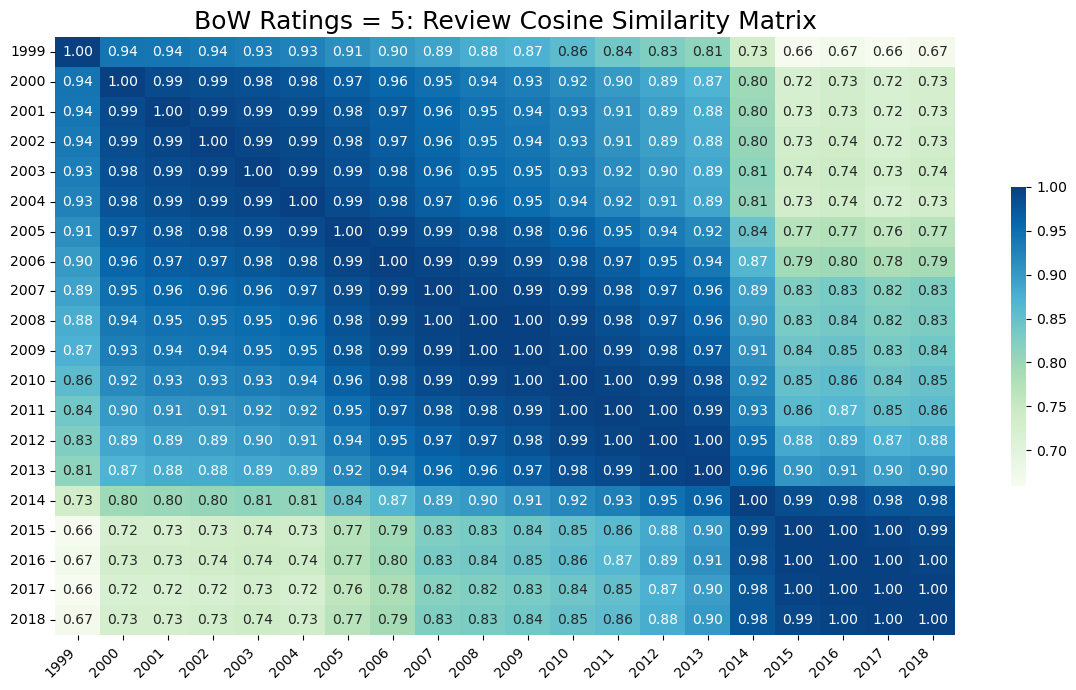

In [13]:
cosine_sim_matrix_bow_5 = cosine_similarity(bow_yearly_average_rating_5)

plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(cosine_sim_matrix_bow_5, annot=True, cmap= "GnBu" , fmt=".2f",
                      xticklabels=bow_yearly_average_rating_5.index, yticklabels=bow_yearly_average_rating_5.index, cbar_kws={'shrink': .5})

# Improving aesthetics
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title('BoW Ratings = 5: Review Cosine Similarity Matrix', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

##### Bag of words similarity of rating = 1

In [14]:
rating = 1

In [15]:
bow_yearly_average_rating_1 = dfm_yearly_sim_avg(df=df_review_norm[df_review_norm["overall"] == rating], start_year=1999, end_year=2018, vectorizer_type=TfidfVectorizer)
bow_yearly_average_rating_1

aa       aaa      aaaa  aaaaaaaaaaaaaaaaaahhhhhhhh  \
1999  0.000000  0.000000  0.000000                    0.000000   
2000  0.005931  0.000000  0.000000                    0.000000   
2001  0.000476  0.000000  0.000000                    0.000000   
2002  0.003831  0.000574  0.000000                    0.000000   
2003  0.004070  0.000000  0.000000                    0.000000   
2004  0.003267  0.000000  0.000000                    0.000000   
2005  0.003669  0.000000  0.000000                    0.000081   
2006  0.002748  0.000065  0.000000                    0.000000   
2007  0.002045  0.000000  0.000000                    0.000000   
2008  0.001793  0.000000  0.000000                    0.000000   
2009  0.001372  0.000076  0.000000                    0.000000   
2010  0.002044  0.000119  0.000047                    0.000000   
2011  0.001854  0.000035  0.000000                    0.000000   
2012  0.000910  0.000050  0.000000                    0.000000   
2013  0.000805  0.000047  0.000000                    0.000000   
2014  0.000671  0.000023  0.000000                    0.000000   
2015  0.000458  0.000028  0.000000                    0.000000   
2016  0.000422  0.000013  0.000000                    0.000000   
2017  0.000317  0.000008  0.000000                    0.000000   
2018  0.000521  0.000000  0.000000                    0.000000   

      aaaaaaahhhhhhh  aaaaaaand  aaaaaand  aaaaaannnnd  aaaaaarrrrrggggg  \
1999        0.000000   0.000000  0.000000     0.000000          0.000000   
2000        0.000000   0.000000  0.000000     0.000000          0.000000   
2001        0.000000   0.000000  0.000000     0.000000          0.000000   
2002        0.000000   0.000000  0.000000     0.000000          0.000000   
2003        0.000000   0.000000  0.000000     0.000000          0.000000   
2004        0.000000   0.000000  0.000000     0.000000          0.000000   
2005        0.000000   0.000000  0.000000     0.000000          0.000000   
2006        0.000000   0.000000  0.000000     0.000000          0.000000   
2007        0.000000   0.000000  0.000000     0.000000          0.000000   
2008        0.000000   0.000000  0.000000     0.000000          0.000000   
2009        0.000000   0.000000  0.000000     0.000000          0.000000   
2010        0.000000   0.000000  0.000000     0.000000          0.000000   
2011        0.000000   0.000000  0.000000     0.000000          0.000000   
2012        0.000000   0.000012  0.000000     0.000000          0.000006   
2013        0.000000   0.000000  0.000000     0.000000          0.000000   
2014        0.000006   0.000000  0.000000     0.000000          0.000000   
2015        0.000000   0.000000  0.000000     0.000000          0.000000   
2016        0.000000   0.000000  0.000006     0.000000          0.000000   
2017        0.000000   0.000000  0.000000     0.000005          0.000000   
2018        0.000000   0.000000  0.000000     0.000000          0.000000   

        aaaahs  ...     zwave     zwus        zx    zykkor       zzz  \
1999  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2000  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2001  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2002  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2003  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2004  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2005  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2006  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2007  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2008  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000066   
2009  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2010  0.000000  ...  0.000000  0.00000  0.000000  0.000000  0.000000   
2011  0.000000  ...  0.000000  0.00000  0.000000  0.000037  0.000000   
2012  0.000000  ... 

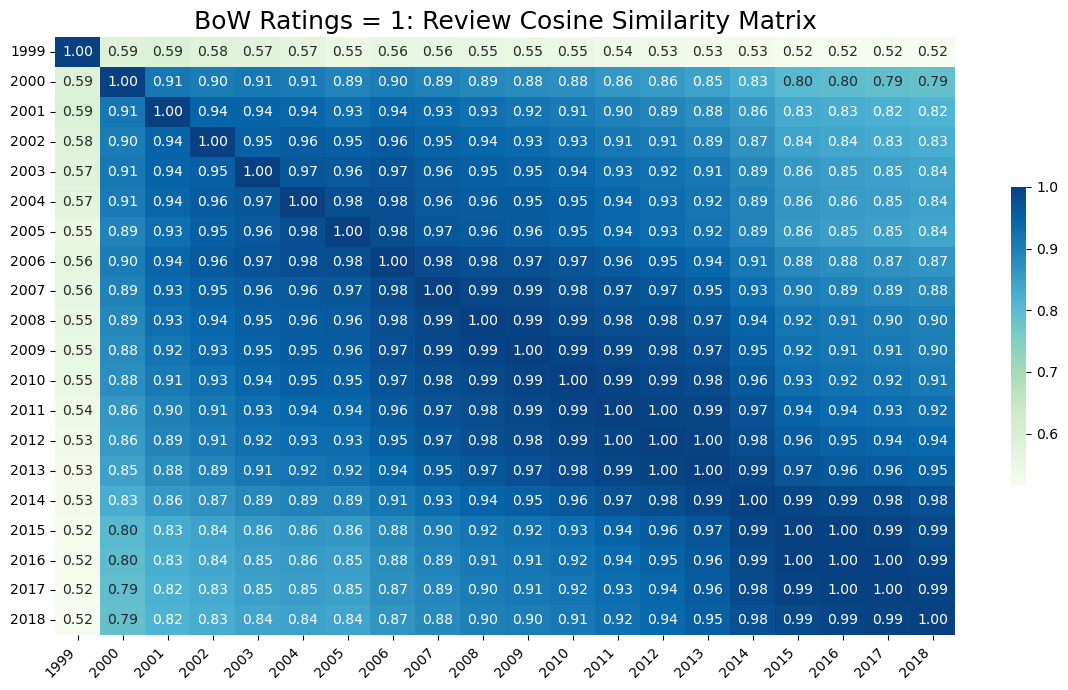

In [16]:
cosine_sim_matrix_bow_1 = cosine_similarity(bow_yearly_average_rating_1)

plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(cosine_sim_matrix_bow_1, annot=True, cmap= "GnBu" , fmt=".2f",
                      xticklabels=bow_yearly_average_rating_1.index, yticklabels=bow_yearly_average_rating_1.index, cbar_kws={'shrink': .5})

# Improving aesthetics
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title('BoW Ratings = 1: Review Cosine Similarity Matrix', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

#### GloVe Embedding Similarity

##### GloVe similarity of all ratings (1-5)

In [17]:
glove_yearly_1_5 = spacy_glove_300_yearly_sim_avg(df=df_review_norm, start_year=1999, end_year=2018)
glove_yearly_1_5

0         1         2         3         4         5         6    \
1999 -0.439317  1.208325 -2.571463  0.327719  1.449208  0.182129  1.724853   
2000 -0.459894  1.257911 -2.661819  0.299106  1.376966  0.169155  1.634199   
2001 -0.448578  1.296820 -2.687222  0.315236  1.418049  0.188743  1.645968   
2002 -0.420815  1.326511 -2.690475  0.358800  1.399275  0.178114  1.631847   
2003 -0.425411  1.362875 -2.697335  0.379596  1.404472  0.179766  1.629381   
2004 -0.417671  1.355335 -2.686143  0.360091  1.395313  0.204542  1.609746   
2005 -0.427024  1.386719 -2.736064  0.385121  1.427923  0.218481  1.575818   
2006 -0.438408  1.382376 -2.746033  0.403611  1.434808  0.208145  1.533217   
2007 -0.437897  1.357673 -2.757896  0.385843  1.452915  0.195781  1.517598   
2008 -0.429278  1.356954 -2.721396  0.390998  1.459465  0.193793  1.473345   
2009 -0.432215  1.366680 -2.704738  0.405387  1.467553  0.189194  1.441383   
2010 -0.447713  1.394794 -2.725244  0.428119  1.468227  0.183938  1.382249   
2011 -0.451524  1.412269 -2.733720  0.449283  1.462808  0.177677  1.345546   
2012 -0.458869  1.407445 -2.702202  0.455711  1.495306  0.163948  1.314018   
2013 -0.474380  1.419628 -2.773254  0.423027  1.497155  0.160483  1.297585   
2014 -0.482727  1.395091 -2.795354  0.410098  1.517830  0.143745  1.292754   
2015 -0.453821  1.360553 -2.752176  0.372977  1.534113  0.115569  1.288021   
2016 -0.437536  1.356168 -2.723764  0.350706  1.529050  0.103911  1.274621   
2017 -0.444453  1.334066 -2.736696  0.321374  1.533657  0.096172  1.285431   
2018 -0.433302  1.342603 -2.770474  0.310130  1.519039  0.083524  1.282793   

           7         8         9    ...       290       291       292  \
1999  3.225396 -3.315207 -0.018780  ...  0.624815 -0.518354  1.273089   
2000  3.200383 -3.353407  0.049709  ...  0.504711 -0.523915  1.322297   
2001  3.228550 -3.360300  0.062626  ...  0.513066 -0.491344  1.321528   
2002  3.245754 -3.327700  0.027587  ...  0.506359 -0.454677  1.338572   
2003  3.259016 -3.302374  0.017614  ...  0.495586 -0.456470  1.354642   
2004  3.243225 -3.273489  0.067110  ...  0.520257 -0.456113  1.359607   
2005  3.276111 -3.277727  0.091039  ...  0.504445 -0.429348  1.368485   
2006  3.300614 -3.287108  0.106778  ...  0.482427 -0.419793  1.373579   
2007  3.297326 -3.324666  0.126669  ...  0.451854 -0.408556  1.372861   
2008  3.289278 -3.335568  0.143351  ...  0.461651 -0.397263  1.358342   
2009  3.308297 -3.319455  0.141571  ...  0.466700 -0.396670  1.337921   
2010  3.326005 -3.324550  0.184258  ...  0.453659 -0.389542  1.327273   
2011  3.322304 -3.319740  0.218177  ...  0.431667 -0.371323  1.328608   
2012  3.334329 -3.318434  0.235573  ...  0.422855 -0.359147  1.279357   
2013  3.350942 -3.335408  0.241570  ...  0.384128 -0.382623  1.245344   
2014  3.397949 -3.344012  0.230800  ...  0.353673 -0.386366  1.234525   
2015  3.411433 -3.339220  0.213693  ...  0.346309 -0.394620  1.209758   
2016  3.406670 -3.345631  0.218872  ...  0.354307 -0.405192  1.181790   
2017  3.430306 -3.331585  0.238006  ...  0.340393 -0.393319  1.140340   
2018  3.439693 -3.323646  0.244397  ...  0.346258 -0.385148  1.141943   

           293       294       295       296       297       298       299  
1999 -0.397866 -1.119306  0.123914  0.437085 -0.688992 -2.340705  0.121471  
2000 -0.366106 -1.212808  0.132457  0.376655 -0.595511 -2.296103  0.054856  
2001 -0.388813 -1.220901  0.160101  0.378210 -0.573211 -2.286685  0.062139  
2002 -0.410898 -1.238914  0.146855  0.382934 -0.584857 -2.302898  0.070779  
2003 -0.452864 -1.256200  0.131303  0.385267 -0.581537 -2.298536  0.091209  
2004 -0.482262 -1.268391  0.088466  0.391613 -0.543367 -2.280292  0.058454  
2005 -0.463898 -1.277409  0.121286  0.377557 -0.548148 -2.245589  0.034858  
2006 -0.444560 -1.276278  0.114759  0.350699 -0.532055 -2.206904  0.021016  
2007 -0.422699 -1.258205  0.111121  0.334558 -0.514873 -2.195654 -0.006431  
2008 -0.408940 -1.267109  0.132834  0.335053 -0.518977 -2.157678 -0.

In [103]:
save_as_pickle(glove_yearly_1_5, "glove_yearly_1_5")

Object saved as glove_yearly_1_5.pkl
Object saved as cosine_sim_matrix_glove_1_5.pkl


In [120]:
# scale the vector representation for visualisation
scaler = StandardScaler()
glove_sim_1_5_scaled = scaler.fit_transform(glove_yearly_1_5)

In [122]:
glove_sim_1_5_scaled = cosine_similarity(glove_sim_1_5_scaled)

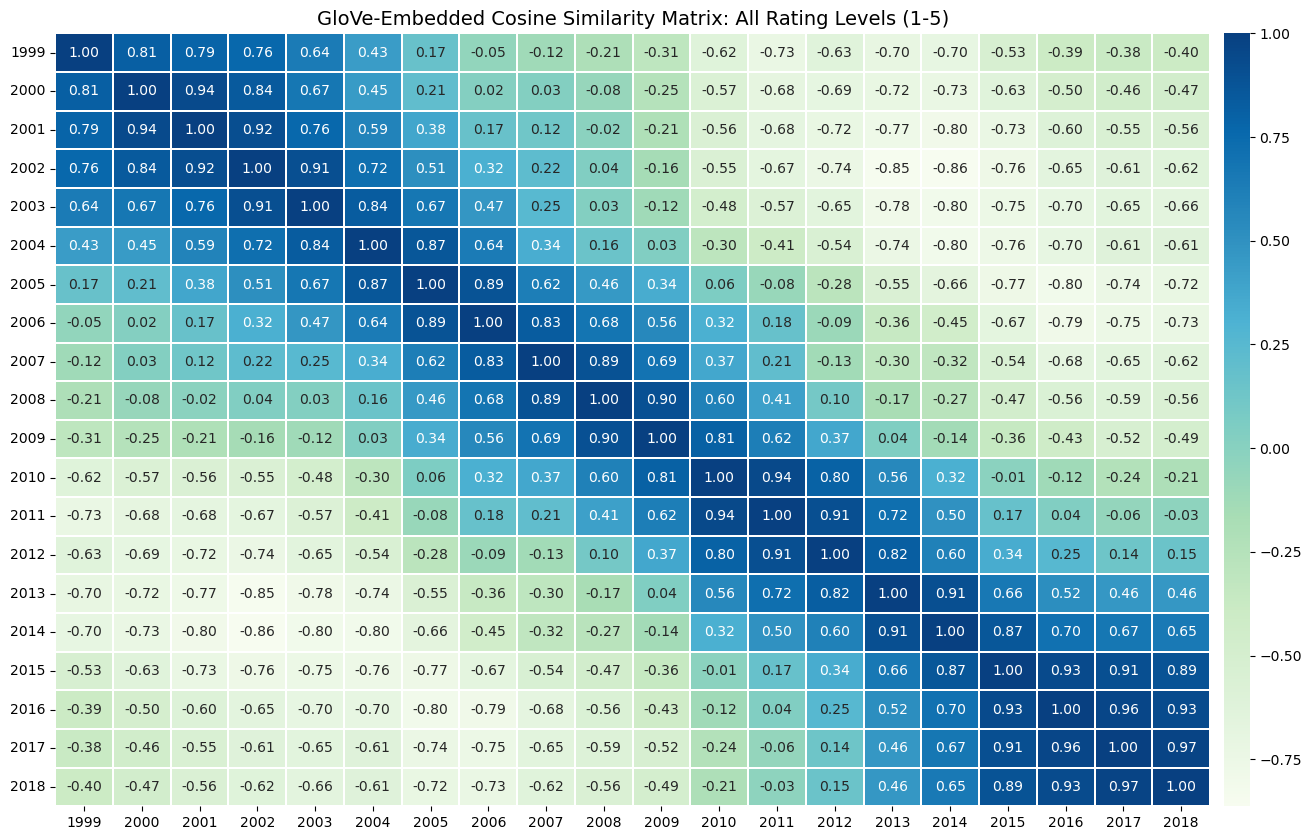

In [125]:
plt.figure(figsize=(14.5, 8.5))
heatmap = sns.heatmap(
    glove_sim_1_5_scaled,
    annot=True,
    cmap="GnBu",
    fmt=".2f",
    xticklabels=glove_yearly_1_5.index,
    yticklabels=glove_yearly_1_5.index,
    cbar_kws={"shrink": 1, "aspect": 30, "pad": 0.01},
    linewidths=0.01,
    linecolor="white",
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=0, horizontalalignment="center"
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title("GloVe-Embedded Cosine Similarity Matrix: All Rating Levels (1-5)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

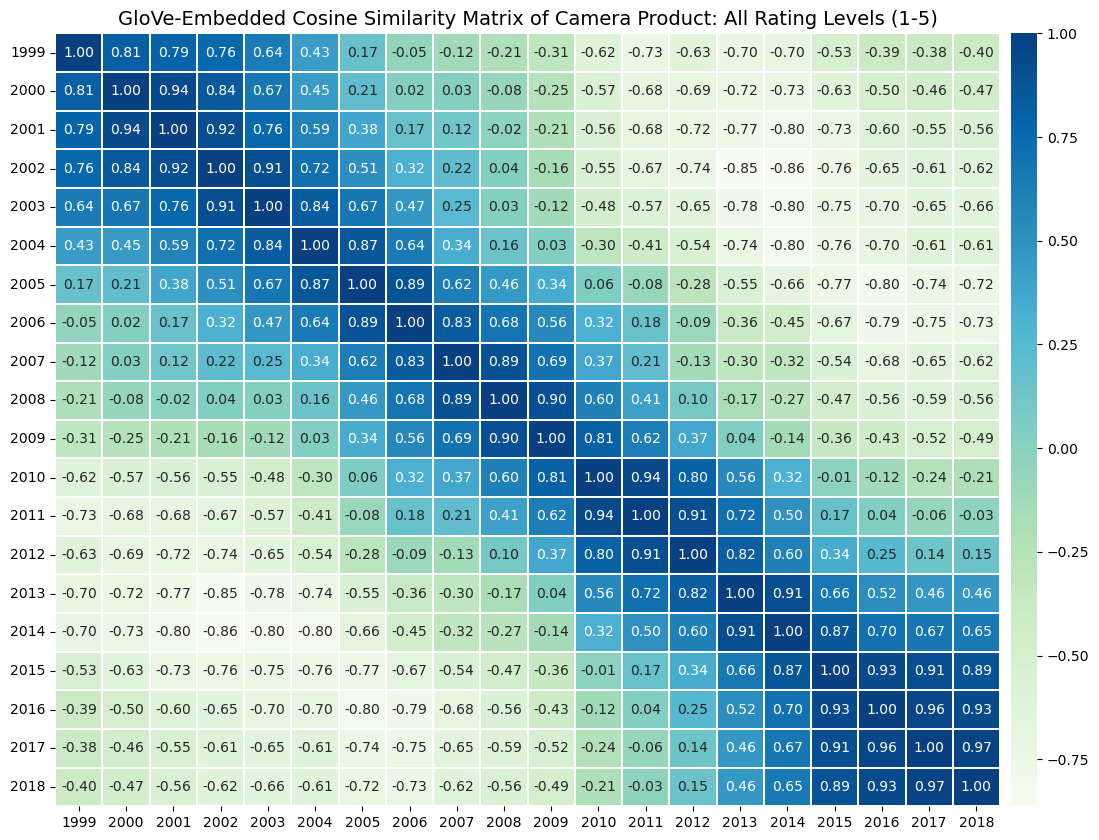

In [160]:
# plot a different size of the presentation use
plt.figure(figsize=(12, 8.5))
heatmap = sns.heatmap(
    glove_sim_1_5_scaled,
    annot=True,
    cmap="GnBu",
    fmt=".2f",
    xticklabels=glove_yearly_1_5.index,
    yticklabels=glove_yearly_1_5.index,
    cbar_kws={"shrink": 1, "aspect": 30, "pad": 0.01},
    linewidths=0.01,
    linecolor="white",
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=0, horizontalalignment="center"
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title("GloVe-Embedded Cosine Similarity Matrix of Camera Product: All Rating Levels (1-5)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

##### GloVe similarity of rating = 5

In [21]:
rating = 5

In [22]:
glove_yearly_average_rating_5 = spacy_glove_300_yearly_sim_avg(df=df_review_norm[df_review_norm["overall"] == rating], start_year=1999, end_year=2018)
glove_yearly_average_rating_5

0         1         2         3         4         5         6    \
1999 -0.444258  1.179646 -2.650660  0.263482  1.415902  0.186646  1.766292   
2000 -0.465122  1.252107 -2.671561  0.303110  1.396137  0.169346  1.650910   
2001 -0.453199  1.284749 -2.728195  0.290079  1.414901  0.166009  1.663842   
2002 -0.432624  1.325798 -2.745477  0.357270  1.393021  0.164474  1.652957   
2003 -0.450826  1.330042 -2.720628  0.346026  1.414573  0.155170  1.653742   
2004 -0.430406  1.338220 -2.725377  0.346181  1.393444  0.164930  1.634836   
2005 -0.445476  1.390803 -2.786952  0.405184  1.420281  0.183632  1.599890   
2006 -0.455750  1.389383 -2.814523  0.416686  1.439722  0.171721  1.540818   
2007 -0.444830  1.346309 -2.830753  0.362419  1.453350  0.148597  1.536147   
2008 -0.441655  1.348614 -2.808477  0.379012  1.452180  0.152352  1.478032   
2009 -0.444969  1.357695 -2.796489  0.390652  1.461722  0.147277  1.450111   
2010 -0.466349  1.384520 -2.818765  0.419558  1.462634  0.137534  1.392807   
2011 -0.464304  1.399861 -2.826905  0.432436  1.456442  0.132036  1.351068   
2012 -0.476573  1.383847 -2.795173  0.427522  1.500146  0.111110  1.334665   
2013 -0.499566  1.386341 -2.882883  0.378314  1.497390  0.102422  1.329947   
2014 -0.508491  1.341931 -2.912281  0.355347  1.536724  0.072870  1.333943   
2015 -0.484493  1.281709 -2.894240  0.299578  1.556151  0.023918  1.332825   
2016 -0.472541  1.274043 -2.870863  0.276926  1.543677  0.011659  1.317074   
2017 -0.470767  1.248220 -2.934003  0.220994  1.551169 -0.019161  1.355583   
2018 -0.448607  1.246044 -2.953293  0.208343  1.527600 -0.039480  1.344310   

           7         8         9    ...       290       291       292  \
1999  3.216829 -3.370542 -0.014442  ...  0.669779 -0.559074  1.282289   
2000  3.200971 -3.400380  0.030090  ...  0.486516 -0.510147  1.318448   
2001  3.210253 -3.416191  0.047051  ...  0.491724 -0.483110  1.336003   
2002  3.249362 -3.406132 -0.012786  ...  0.473382 -0.435054  1.341218   
2003  3.263451 -3.367470 -0.013896  ...  0.478501 -0.469734  1.361807   
2004  3.234897 -3.347599  0.044535  ...  0.489644 -0.450034  1.380873   
2005  3.288350 -3.354441  0.060822  ...  0.463698 -0.406451  1.385797   
2006  3.304845 -3.355444  0.077214  ...  0.437044 -0.397680  1.394716   
2007  3.278665 -3.390935  0.107366  ...  0.401936 -0.387480  1.383592   
2008  3.274094 -3.399026  0.143242  ...  0.411053 -0.368379  1.372095   
2009  3.301777 -3.389748  0.136081  ...  0.414501 -0.378038  1.358223   
2010  3.328507 -3.398586  0.181517  ...  0.405642 -0.367771  1.344236   
2011  3.315524 -3.378915  0.217172  ...  0.377407 -0.351805  1.344080   
2012  3.319162 -3.373371  0.230163  ...  0.370474 -0.341509  1.295700   
2013  3.350627 -3.399266  0.240707  ...  0.318867 -0.361916  1.263657   
2014  3.409067 -3.412873  0.225074  ...  0.273441 -0.370167  1.260716   
2015  3.426409 -3.427379  0.201728  ...  0.242037 -0.374842  1.247777   
2016  3.423338 -3.434934  0.207541  ...  0.244360 -0.382792  1.225222   
2017  3.424578 -3.431240  0.224254  ...  0.214844 -0.366941  1.190293   
2018  3.427464 -3.429183  0.234485  ...  0.215432 -0.360862  1.189149   

           293       294       295       296       297       298       299  
1999 -0.378509 -1.103489  0.080416  0.429861 -0.665464 -2.391434  0.042765  
2000 -0.344552 -1.199467  0.148371  0.360835 -0.611895 -2.330168  0.001645  
2001 -0.388465 -1.199714  0.143630  0.386154 -0.567196 -2.336268 -0.009953  
2002 -0.389263 -1.216750  0.152938  0.366956 -0.583225 -2.345148  0.018773  
2003 -0.461370 -1.236080  0.099457  0.388001 -0.571010 -2.370406  0.042908  
2004 -0.475365 -1.256991  0.078133  0.392488 -0.541828 -2.336160 -0.006299  
2005 -0.471631 -1.260724  0.109884  0.380762 -0.547126 -2.304732 -0.023161  
2006 -0.448817 -1.271410  0.105349  0.346491 -0.529557 -2.260972 -0.035413  
2007 -0.437503 -1.256889  0.082111  0.317409 -0.488138 -2.256372 -0.081986  
2008 -0.430650 -1.268972  0.105117  0.313191 -0.485771 -2.202247 -0.

In [126]:
save_as_pickle(glove_yearly_average_rating_5, "glove_yearly_average_rating_5")

Object saved as glove_yearly_average_rating_5.pkl


In [127]:
# scale the vector representation for visualisation
scaler = StandardScaler()
glove_yearly_average_rating_5_scaled = scaler.fit_transform(glove_yearly_average_rating_5)

In [128]:
glove_sim_5_scaled = cosine_similarity(glove_yearly_average_rating_5_scaled)

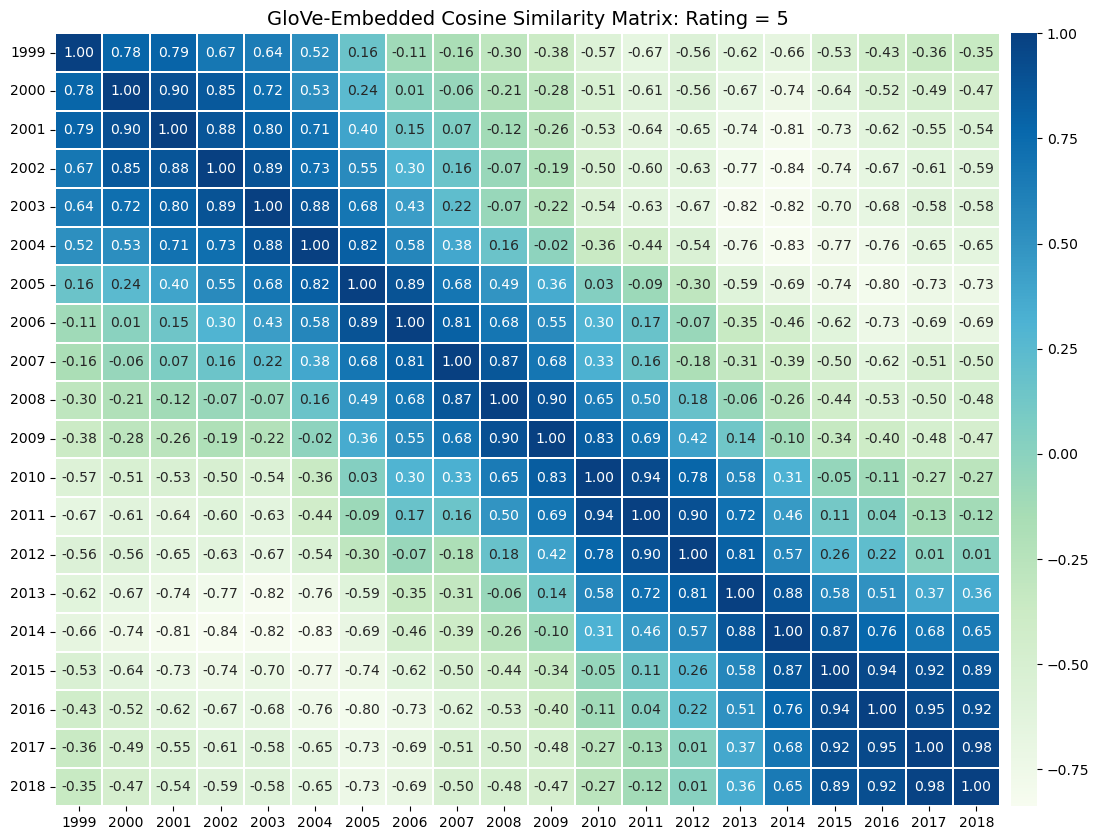

In [140]:
plt.figure(figsize=(12, 8.5))
heatmap = sns.heatmap(
    glove_sim_5_scaled,
    annot=True,
    cmap="GnBu",
    fmt=".2f",
    xticklabels=glove_yearly_average_rating_5.index,
    yticklabels=glove_yearly_average_rating_5.index,
    cbar_kws={"shrink": 1, "aspect": 30, "pad": 0.01},
    linewidths=0.01,
    linecolor="white",
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=0, horizontalalignment="center"
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title(
    "GloVe-Embedded Cosine Similarity Matrix: Rating = 5", fontsize=14
)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


##### GloVe similarity of rating = 1

In [26]:
rating = 1

In [27]:
glove_yearly_average_rating_1 = spacy_glove_300_yearly_sim_avg(df=df_review_norm[df_review_norm["overall"] == rating], start_year=1999, end_year=2018)
glove_yearly_average_rating_1

0         1         2         3         4         5         6    \
1999 -0.240342  0.807624 -1.835873  0.387903  1.675999  0.318120  1.286981   
2000 -0.325724  1.079930 -2.462211  0.082860  1.303725  0.329080  1.475713   
2001 -0.395082  1.171742 -2.449883  0.180446  1.383224  0.407403  1.507042   
2002 -0.396993  1.162330 -2.413958  0.214818  1.491117  0.374910  1.460027   
2003 -0.336029  1.244362 -2.595682  0.143656  1.375045  0.412208  1.472200   
2004 -0.415325  1.218171 -2.514044  0.198676  1.461306  0.431742  1.449134   
2005 -0.425505  1.186416 -2.544518  0.139292  1.473312  0.443224  1.464880   
2006 -0.412905  1.165704 -2.497349  0.151865  1.431316  0.441886  1.440903   
2007 -0.439072  1.168873 -2.449655  0.239025  1.498698  0.441667  1.404449   
2008 -0.445875  1.175023 -2.431767  0.227542  1.545031  0.437896  1.398033   
2009 -0.450579  1.180403 -2.422323  0.257336  1.558433  0.429242  1.375073   
2010 -0.470075  1.217879 -2.452369  0.245702  1.539602  0.431654  1.343291   
2011 -0.494981  1.248280 -2.477671  0.290704  1.545575  0.419415  1.311287   
2012 -0.471022  1.263667 -2.459461  0.304786  1.565432  0.407101  1.267324   
2013 -0.493916  1.248164 -2.420111  0.305391  1.588320  0.427640  1.219404   
2014 -0.508038  1.286342 -2.432785  0.334927  1.566657  0.426856  1.199636   
2015 -0.480028  1.303988 -2.382920  0.337018  1.568420  0.398734  1.207056   
2016 -0.444914  1.305921 -2.334132  0.326457  1.577883  0.385436  1.194673   
2017 -0.464658  1.295088 -2.358168  0.326921  1.583356  0.391789  1.194538   
2018 -0.461486  1.326683 -2.390821  0.323808  1.565177  0.374657  1.202517   

           7         8         9    ...       290       291       292  \
1999  3.048234 -3.392345  0.343321  ...  0.603255 -0.581677  0.843046   
2000  2.919763 -2.957572  0.174205  ...  0.676804 -0.590101  1.118479   
2001  3.101978 -3.146506  0.197293  ...  0.731554 -0.583495  1.050762   
2002  3.105232 -3.010355  0.206417  ...  0.709284 -0.491592  0.978707   
2003  3.082500 -3.093460  0.293418  ...  0.743066 -0.502504  1.055636   
2004  3.100347 -3.033631  0.222710  ...  0.705707 -0.479770  1.068918   
2005  3.070902 -3.006072  0.237680  ...  0.740413 -0.505238  1.065051   
2006  3.071503 -3.021676  0.258372  ...  0.717714 -0.460680  1.054947   
2007  3.100813 -3.109257  0.254664  ...  0.713554 -0.455446  1.066898   
2008  3.101834 -3.118787  0.249275  ...  0.734508 -0.455399  1.049948   
2009  3.099984 -3.084725  0.252926  ...  0.719693 -0.438319  1.036832   
2010  3.101143 -3.091620  0.258107  ...  0.686908 -0.447020  1.060956   
2011  3.116702 -3.105064  0.300438  ...  0.663786 -0.418056  1.069268   
2012  3.152242 -3.083963  0.302356  ...  0.664265 -0.420300  1.041381   
2013  3.167029 -3.093588  0.284250  ...  0.660242 -0.430741  0.966709   
2014  3.218868 -3.095700  0.278431  ...  0.652220 -0.417337  0.953412   
2015  3.254023 -3.092458  0.261289  ...  0.665705 -0.417477  0.925603   
2016  3.274496 -3.117918  0.266017  ...  0.672197 -0.429643  0.885372   
2017  3.278344 -3.099415  0.275603  ...  0.665544 -0.431876  0.849840   
2018  3.271028 -3.087208  0.284317  ...  0.676097 -0.413921  0.846538   

           293       294       295       296       297       298       299  
1999 -0.009566 -1.121912  0.151961  0.304795 -0.760669 -2.042886  0.272671  
2000 -0.472971 -1.247851 -0.021400  0.259142 -0.368282 -2.113213  0.200857  
2001 -0.429475 -1.312860 -0.020888  0.231913 -0.432983 -2.014407  0.202432  
2002 -0.447395 -1.327267  0.026204  0.191191 -0.500613 -2.051142  0.309586  
2003 -0.493476 -1.358230  0.021973  0.218116 -0.372409 -2.023508  0.182201  
2004 -0.528211 -1.371557 -0.006660  0.222314 -0.453204 -2.009614  0.203588  
2005 -0.472132 -1.336188  0.028414  0.198607 -0.458416 -2.012971  0.190592  
2006 -0.454408 -1.293294  0.000913  0.214652 -0.425896 -1.997171  0.181899  
2007 -0.393920 -1.262901  0.069458  0.229823 -0.505096 -1.946888  0.179911  
2008 -0.384955 -1.267671  0.108502  0.246336 -0.535946 -1.928897  0.

In [147]:
save_as_pickle(glove_yearly_average_rating_1, "glove_yearly_average_rating_1")

Object saved as glove_yearly_average_rating_1.pkl


In [148]:
# scale the vector representation for visualisation
scaler = StandardScaler()
glove_yearly_average_rating_1_scaled = scaler.fit_transform(glove_yearly_average_rating_1)

In [149]:
glove_sim_1_scaled = cosine_similarity(glove_yearly_average_rating_1_scaled)

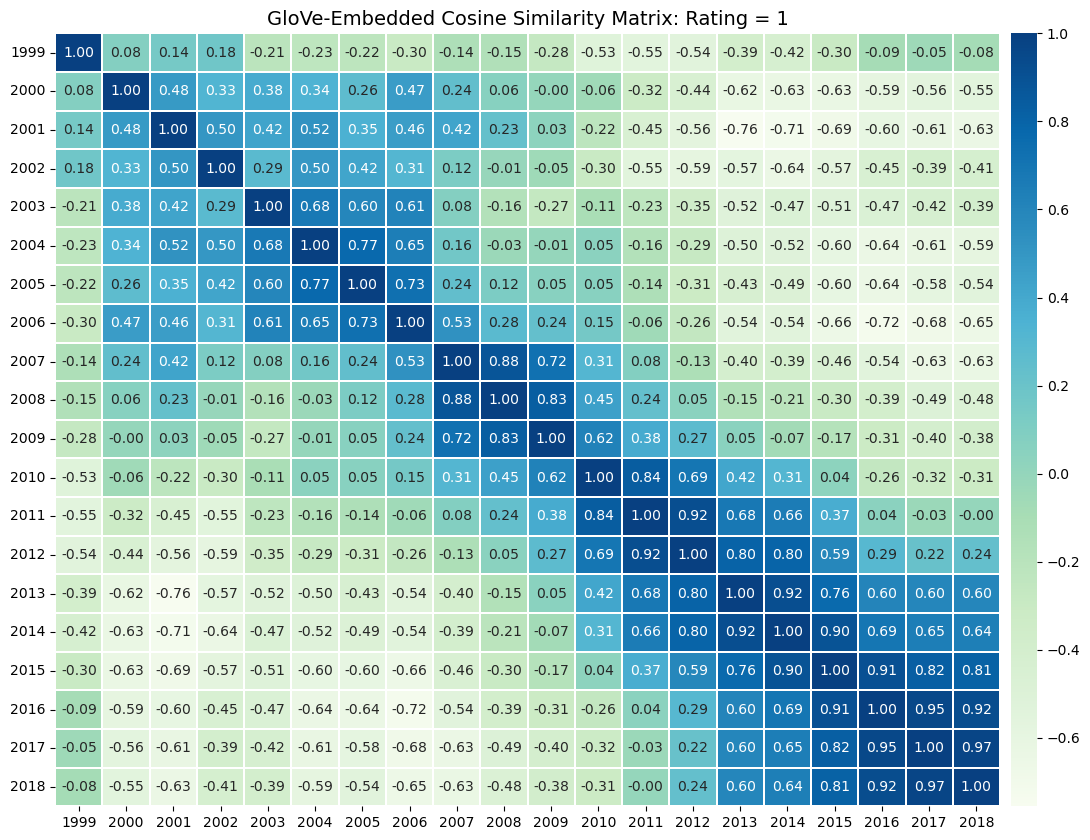

In [150]:
plt.figure(figsize=(12, 8.5))
heatmap = sns.heatmap(
    glove_sim_1_scaled,
    annot=True,
    cmap="GnBu",
    fmt=".2f",
    xticklabels=glove_yearly_average_rating_1.index,
    yticklabels=glove_yearly_average_rating_1.index,
    cbar_kws={"shrink": 1, "aspect": 30, "pad": 0.01},
    linewidths=0.01,
    linecolor="white",
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=0, horizontalalignment="center"
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title("GloVe-Embedded Cosine Similarity Matrix: Rating = 1", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

#### GloVe Similarity of All Electronics category all ratings (1-5)

In [31]:
glove_yearly_alle_1_5 = spacy_glove_300_yearly_sim_avg(df=df_review_all_cat_subset_norm, start_year=1999, end_year=2018)
glove_yearly_alle_1_5

0         1         2         3         4         5         6    \
1999 -0.627533  1.231134 -1.961051  0.183050  1.230054  0.425706  1.298131   
2000 -0.611819  1.255315 -1.956756  0.217594  1.284821  0.417016  1.219465   
2001 -0.561170  1.247592 -1.970263  0.269201  1.279624  0.417052  1.241228   
2002 -0.531230  1.269678 -1.928806  0.241191  1.283241  0.429167  1.216146   
2003 -0.550471  1.295815 -1.952821  0.282302  1.314143  0.395141  1.192878   
2004 -0.550418  1.279679 -1.918258  0.247055  1.309494  0.416481  1.196216   
2005 -0.525357  1.308740 -1.967290  0.229714  1.333838  0.410722  1.139928   
2006 -0.534553  1.316611 -2.030519  0.237802  1.308007  0.381372  1.148088   
2007 -0.511161  1.318899 -2.126951  0.213970  1.331307  0.343756  1.164640   
2008 -0.495047  1.342005 -2.111733  0.228399  1.346973  0.327843  1.152941   
2009 -0.508862  1.356735 -2.132862  0.250637  1.342728  0.307541  1.133150   
2010 -0.510521  1.367060 -2.151714  0.281620  1.344702  0.307812  1.106624   
2011 -0.513153  1.375215 -2.187835  0.280278  1.318315  0.289710  1.102837   
2012 -0.525583  1.353199 -2.216471  0.272808  1.347779  0.279101  1.110542   
2013 -0.542648  1.368560 -2.297903  0.238628  1.329125  0.263550  1.111274   
2014 -0.549833  1.349872 -2.317284  0.233954  1.351288  0.234888  1.124500   
2015 -0.550960  1.327144 -2.329319  0.205005  1.365072  0.200546  1.138878   
2016 -0.557358  1.338173 -2.332957  0.203169  1.367599  0.195135  1.116429   
2017 -0.576966  1.339208 -2.400284  0.183204  1.388284  0.190364  1.137520   
2018 -0.587073  1.356500 -2.432324  0.171083  1.380799  0.186845  1.146917   

           7         8         9    ...       290       291       292  \
1999  3.214815 -2.872496 -0.312457  ...  0.607401 -0.631126  0.806181   
2000  3.208859 -3.100574 -0.055309  ...  0.538714 -0.602212  0.843583   
2001  3.226249 -3.139163  0.010212  ...  0.548762 -0.524975  0.842128   
2002  3.237446 -3.118926 -0.011060  ...  0.561773 -0.504925  0.807608   
2003  3.259551 -3.101600 -0.027807  ...  0.515209 -0.503651  0.813169   
2004  3.217623 -3.063390 -0.067713  ...  0.598106 -0.510787  0.786234   
2005  3.265220 -3.087838  0.017471  ...  0.591069 -0.523827  0.797774   
2006  3.274636 -3.085214  0.000260  ...  0.552953 -0.506583  0.842289   
2007  3.298477 -3.122060  0.049971  ...  0.506885 -0.507379  0.883596   
2008  3.314578 -3.161298  0.081268  ...  0.501823 -0.500259  0.862506   
2009  3.352740 -3.167081  0.091935  ...  0.496483 -0.499055  0.869192   
2010  3.375082 -3.195937  0.134628  ...  0.504238 -0.486033  0.874261   
2011  3.407122 -3.214729  0.155267  ...  0.511755 -0.510713  0.895710   
2012  3.427618 -3.231980  0.173634  ...  0.520852 -0.515525  0.890761   
2013  3.471752 -3.252828  0.187678  ...  0.485958 -0.533939  0.877525   
2014  3.514286 -3.266341  0.176383  ...  0.465788 -0.524223  0.877956   
2015  3.534134 -3.274632  0.146156  ...  0.448955 -0.498891  0.892866   
2016  3.530232 -3.291080  0.147712  ...  0.448219 -0.495563  0.882533   
2017  3.561181 -3.268330  0.178223  ...  0.423783 -0.467119  0.846552   
2018  3.566216 -3.273206  0.185636  ...  0.425574 -0.453159  0.856534   

           293       294       295       296       297       298       299  
1999 -0.186192 -0.947884 -0.185411  0.258535 -0.723592 -2.390748  0.537234  
2000 -0.201700 -1.043112 -0.068552  0.219589 -0.635663 -2.252383  0.448019  
2001 -0.171575 -1.034885  0.016841  0.192097 -0.625798 -2.194510  0.479132  
2002 -0.178117 -1.034599  0.038002  0.194578 -0.642530 -2.203921  0.528055  
2003 -0.199635 -1.027321  0.056777  0.160904 -0.696026 -2.172939  0.552150  
2004 -0.247348 -1.035082  0.025682  0.228362 -0.686136 -2.179646  0.580065  
2005 -0.266483 -1.045045 -0.004079  0.155440 -0.633666 -2.161800  0.599198  
2006 -0.283516 -1.041886  0.012813  0.174001 -0.633053 -2.155531  0.545463  
2007 -0.284098 -1.050606  0.022185  0.154871 -0.607982 -2.156903  0.495579  
2008 -0.266988 -1.047794  0.072488  0.152430 -0.628150 -2.128581  0.

In [151]:
save_as_pickle(glove_yearly_alle_1_5, "glove_yearly_alle_1_5")

Object saved as glove_yearly_alle_1_5.pkl


In [152]:
# scale the vector representation for visualisation
scaler = StandardScaler()
glove_yearly_alle_1_5_scaled = scaler.fit_transform(glove_yearly_alle_1_5)

In [153]:
glove_sim_alle_1_5_scaled = cosine_similarity(glove_yearly_alle_1_5_scaled)

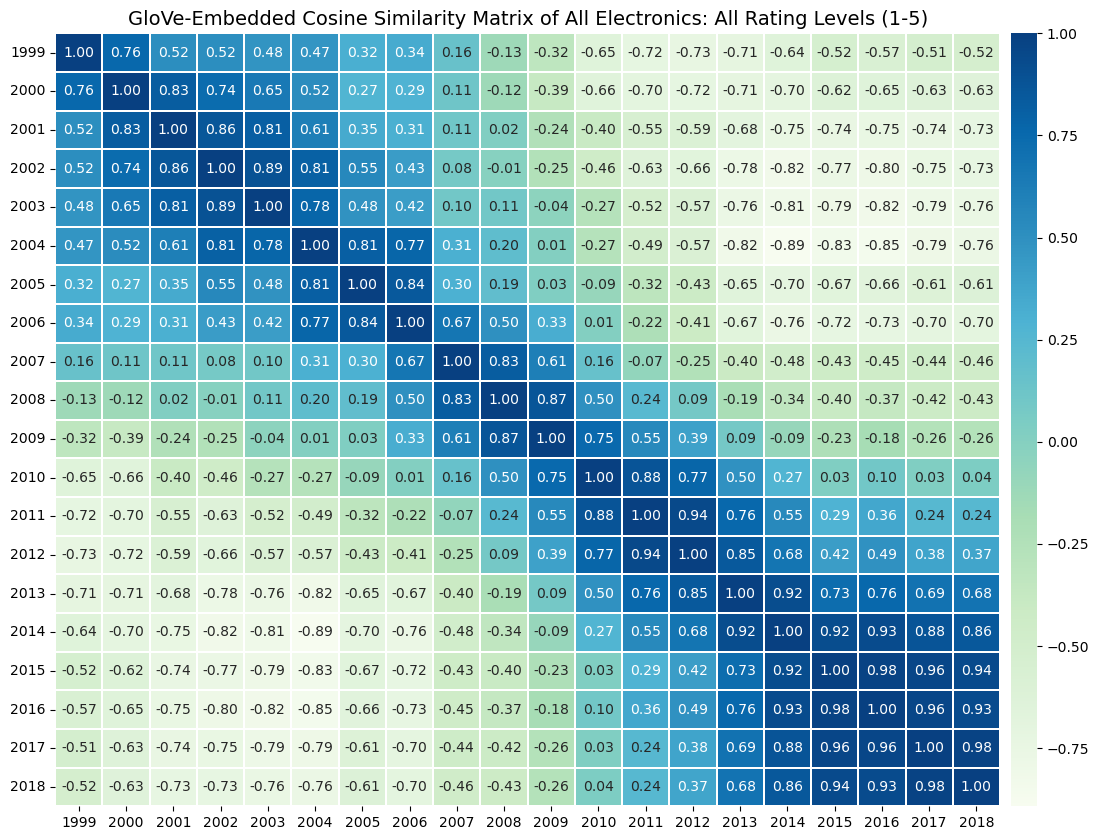

In [161]:
plt.figure(figsize=(12, 8.5))
heatmap = sns.heatmap(
    glove_sim_alle_1_5_scaled,
    annot=True,
    cmap="GnBu",
    fmt=".2f",
    xticklabels=glove_yearly_alle_1_5.index,
    yticklabels=glove_yearly_alle_1_5.index,
    cbar_kws={"shrink": 1, "aspect": 30, "pad": 0.01},
    linewidths=0.01,
    linecolor="white",
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=0, horizontalalignment="center"
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title("GloVe-Embedded Cosine Similarity Matrix of All Electronics: All Rating Levels (1-5)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Complexity Analysis

Standard Metrics: 
- Flesch Reading Ease: Measures how easy a text is to read. The score is based on the average length of sentences and the average number of syllables per word. 
- Flesch-Kincaid Grade Level: Translates the Flesch Reading Ease Score into a U.S. school grade level. It's also based on sentence length and syllable count. This is commonly used in educational settings.
- Gunning Fog Index: Estimates the years of formal education a person needs to understand the text on the first reading. It considers average sentence length and the percentage of complex words (three or more syllables).
- Dale–Chall Readability: Dale-Chall Readability is a readability test that provides a numeric gauge of the comprehension difficulty that readers come upon when reading a text. It uses a list of 3000 words that groups of fourth-grade American students could reliably understand, considering any word not on that list to be difficult.

Language Diversity:
- TTR (Type-Token Ratio): TTR is the ratio obtained by dividing the types (the total number of different words) occurring in a text or utterance by its tokens (the total number of words). It's good for texts of similar lengths but not ideal for comparing texts of widely differing lengths.
- MTLD (Measure of Textual Lexical Diversity): This measure calculates the average length of continuous sequences in the text where the type-token ratio remains above a certain threshold. It is considered more robust against text length variations.
- HDD (Hypergeometric Distribution D): This is a probabilistic measure that estimates the likelihood of encountering new words as a text progresses. It tends to be less sensitive to text length.

In [38]:
# Flesch Reading Ease
def flesch_reading_ease(text):
    return textstat.flesch_reading_ease(text)

# Flesch-Kincaid Grade Level
def flesch_kincaid_grade(text):
    return textstat.flesch_kincaid_grade(text)

# Gunning Fog Index
def gunning_fog(text):
    return textstat.gunning_fog(text)

# Dale-Chall Readability Score
def dale_chall_readability_score(text):
    return textstat.dale_chall_readability_score(text)

# Type-Token Ratio (TTR)
def type_token_ratio(text):
    words = text.split() 
    total_words = len(words)
    unique_words = len(set(words))
    return unique_words / total_words if total_words > 0 else 0

# Measure of Textual Lexical Diversity (MTLD)
def measure_of_textual_lexical_diversity(text):
    lex = LexicalRichness(text)
    return lex.mtld(threshold=0.72)  # Threshold can be adjusted

# Hypergeometric Distribution D (HDD)
def hypergeometric_distribution_d(text):
    lex = LexicalRichness(text)
    return lex.hdd()

### Overall Complexity and Diversity

In [39]:
df_review_norm['flesch_reading_ease'] = df_review_norm['reviewText'].apply(flesch_reading_ease)
df_review_norm['flesch_kincaid_grade'] = df_review_norm['reviewText'].apply(flesch_kincaid_grade)
df_review_norm['gunning_fog'] = df_review_norm['reviewText'].apply(gunning_fog)
df_review_norm['dale_chall_readability_score'] = df_review_norm['reviewText'].apply(dale_chall_readability_score)

In [40]:
df_review_norm['type_token_ratio'] = df_review_norm['reviewText'].apply(type_token_ratio)
df_review_norm['measure_of_textual_lexical_diversity'] = df_review_norm['reviewText'].apply(measure_of_textual_lexical_diversity)

In [41]:
sns.reset_orig() # reset sns theme

#### Violin plot

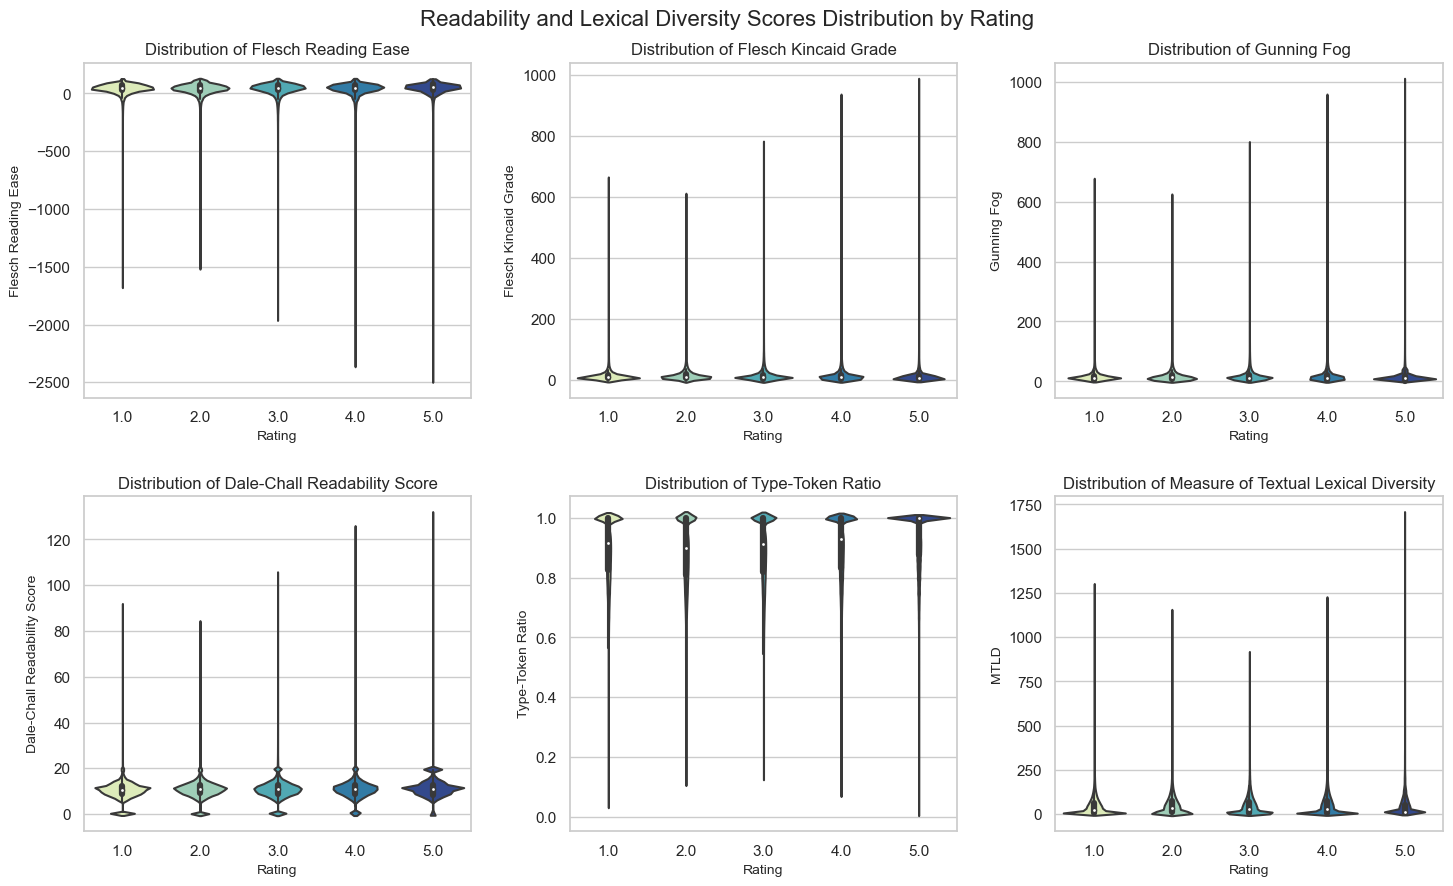

In [42]:
sns.set_theme(style="whitegrid")
palette = "YlGnBu"
plt.figure(figsize=(15, 9))  

# Violin plot for Flesch Reading Ease
plt.subplot(2, 3, 1)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['flesch_reading_ease'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Flesch Reading Ease', fontsize=10)
plt.title('Distribution of Flesch Reading Ease', fontsize=12)

# Violin plot for Flesch Kincaid Grade
plt.subplot(2, 3, 2)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['flesch_kincaid_grade'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Flesch Kincaid Grade', fontsize=10)
plt.title('Distribution of Flesch Kincaid Grade', fontsize=12)

# Violin plot for Gunning Fog
plt.subplot(2, 3, 3)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['gunning_fog'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Gunning Fog', fontsize=10)
plt.title('Distribution of Gunning Fog', fontsize=12)

# Violin plot for Dale-Chall Readability Score
plt.subplot(2, 3, 4)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['dale_chall_readability_score'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Dale-Chall Readability Score', fontsize=10)
plt.title('Distribution of Dale-Chall Readability Score', fontsize=12)

# Violin plot for Type-Token Ratio
plt.subplot(2, 3, 5)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['type_token_ratio'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Type-Token Ratio', fontsize=10)
plt.title('Distribution of Type-Token Ratio', fontsize=12)

# Violin plot for Measure of Textual Lexical Diversity
plt.subplot(2, 3, 6)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['measure_of_textual_lexical_diversity'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('MTLD', fontsize=10)
plt.title('Distribution of Measure of Textual Lexical Diversity', fontsize=12)

plt.tight_layout(pad=2.0)
plt.suptitle('Readability and Lexical Diversity Scores Distribution by Rating', fontsize=16, y=1)
plt.show()

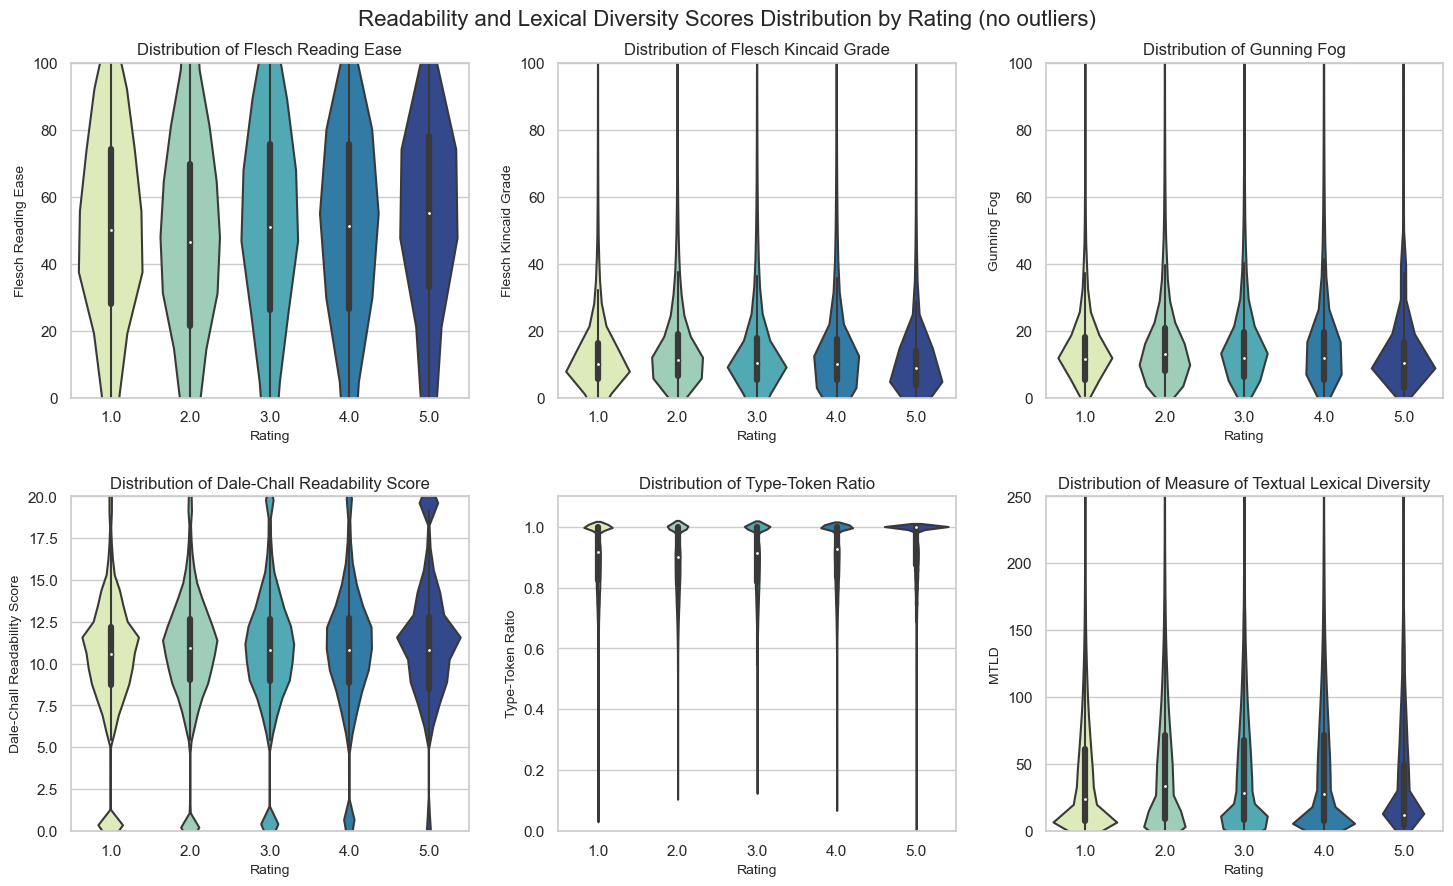

In [43]:
sns.set_theme(style="whitegrid")
palette = "YlGnBu"
plt.figure(figsize=(15, 9))  

# Box plot for Flesch Reading Ease
plt.subplot(2, 3, 1)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['flesch_reading_ease'], palette=palette)
plt.ylim(0, 100)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Flesch Reading Ease', fontsize=10)
plt.title('Distribution of Flesch Reading Ease', fontsize=12)

# Box plot for Flesch Kincaid Grade
plt.subplot(2, 3, 2)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['flesch_kincaid_grade'], palette=palette)
plt.ylim(0, 100)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Flesch Kincaid Grade', fontsize=10)
plt.title('Distribution of Flesch Kincaid Grade', fontsize=12)

# Box plot for Gunning Fog
plt.subplot(2, 3, 3)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['gunning_fog'], palette=palette)
plt.ylim(0, 100)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Gunning Fog', fontsize=10)
plt.title('Distribution of Gunning Fog', fontsize=12)

# Box plot for Dale-Chall Readability Score
plt.subplot(2, 3, 4)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['dale_chall_readability_score'], palette=palette)
plt.ylim(0, 20)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Dale-Chall Readability Score', fontsize=10)
plt.title('Distribution of Dale-Chall Readability Score', fontsize=12)

# Box plot for Type-Token Ratio
plt.subplot(2, 3, 5)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['type_token_ratio'], palette=palette)
plt.ylim(0, 1.1)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Type-Token Ratio', fontsize=10)
plt.title('Distribution of Type-Token Ratio', fontsize=12)

# Box plot for Measure of Textual Lexical Diversity
plt.subplot(2, 3, 6)
sns.violinplot(x=df_review_norm["overall"], y=df_review_norm['measure_of_textual_lexical_diversity'], palette=palette)
plt.ylim(0, 250)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('MTLD', fontsize=10)
plt.title('Distribution of Measure of Textual Lexical Diversity', fontsize=12)

plt.tight_layout(pad=2.0)
plt.suptitle('Readability and Lexical Diversity Scores Distribution by Rating (no outliers)', fontsize=16, y=1)
plt.show()

#### Box plot

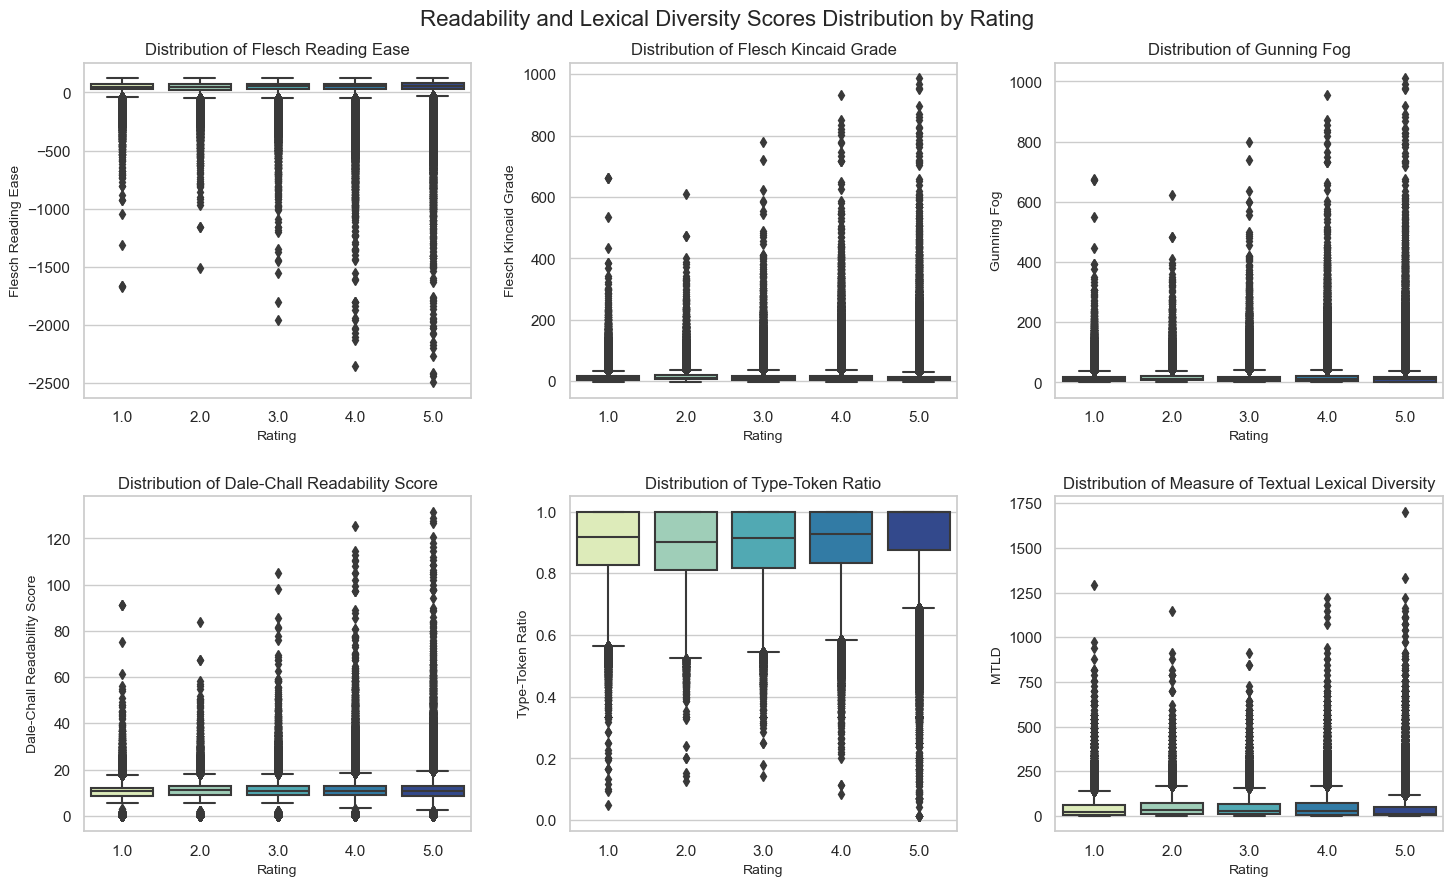

In [44]:
sns.set_theme(style="whitegrid")
palette = "YlGnBu"
plt.figure(figsize=(15, 9))  

# Box plot for Flesch Reading Ease
plt.subplot(2, 3, 1)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['flesch_reading_ease'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Flesch Reading Ease', fontsize=10)
plt.title('Distribution of Flesch Reading Ease', fontsize=12)

# Box plot for Flesch Kincaid Grade
plt.subplot(2, 3, 2)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['flesch_kincaid_grade'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Flesch Kincaid Grade', fontsize=10)
plt.title('Distribution of Flesch Kincaid Grade', fontsize=12)

# Box plot for Gunning Fog
plt.subplot(2, 3, 3)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['gunning_fog'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Gunning Fog', fontsize=10)
plt.title('Distribution of Gunning Fog', fontsize=12)

# Box plot for Dale-Chall Readability Score
plt.subplot(2, 3, 4)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['dale_chall_readability_score'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Dale-Chall Readability Score', fontsize=10)
plt.title('Distribution of Dale-Chall Readability Score', fontsize=12)

# Box plot for Type-Token Ratio
plt.subplot(2, 3, 5)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['type_token_ratio'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Type-Token Ratio', fontsize=10)
plt.title('Distribution of Type-Token Ratio', fontsize=12)

# Box plot for Measure of Textual Lexical Diversity
plt.subplot(2, 3, 6)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['measure_of_textual_lexical_diversity'], palette=palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('MTLD', fontsize=10)
plt.title('Distribution of Measure of Textual Lexical Diversity', fontsize=12)

plt.tight_layout(pad=2.0)
plt.suptitle('Readability and Lexical Diversity Scores Distribution by Rating', fontsize=16, y=1)
plt.show()

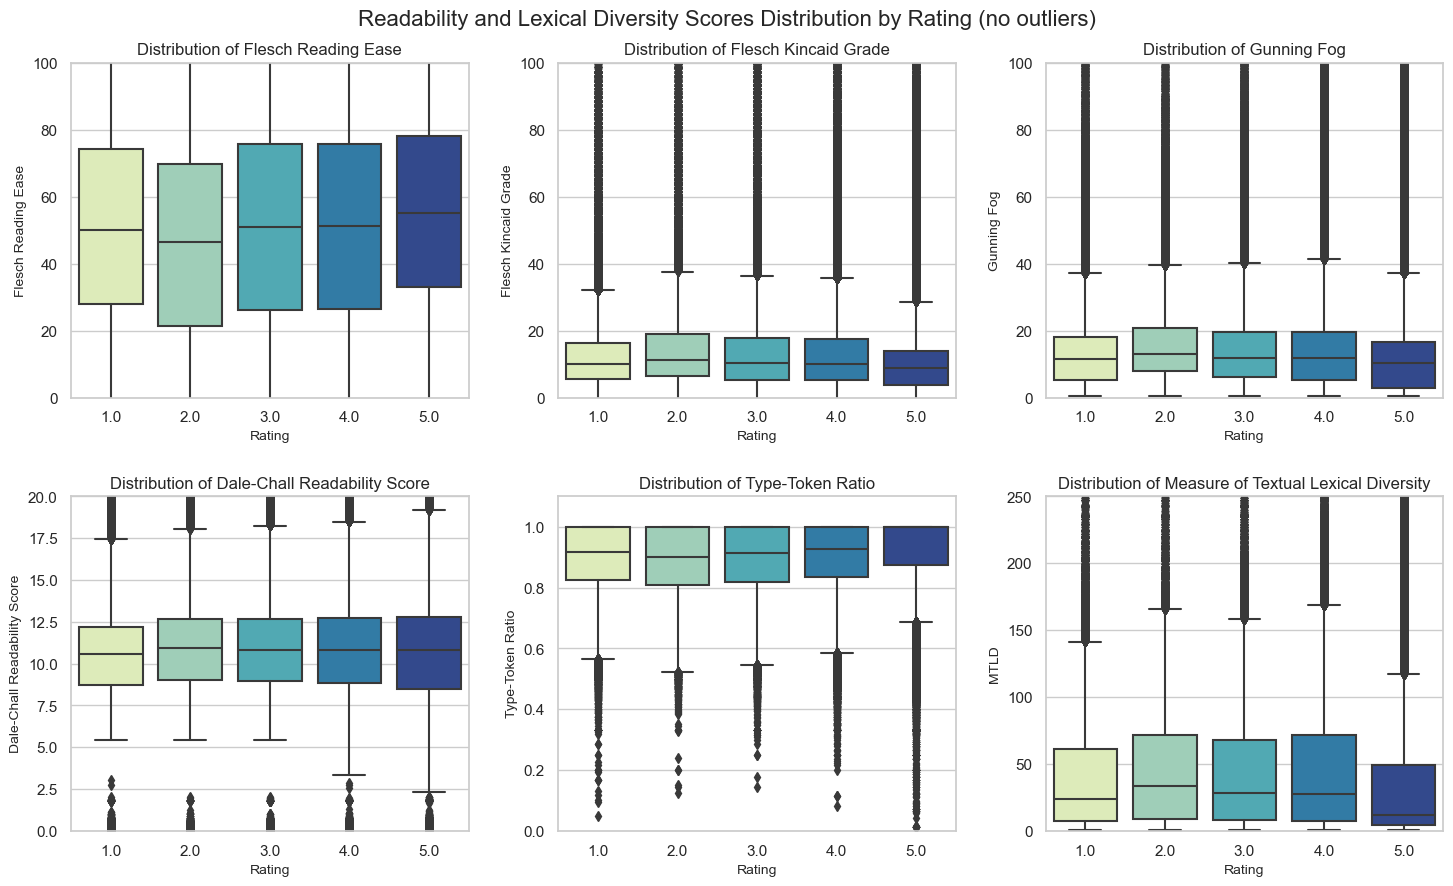

In [70]:
sns.set_theme(style="whitegrid")
palette = "YlGnBu"
plt.figure(figsize=(15, 9))  

# Box plot for Flesch Reading Ease
plt.subplot(2, 3, 1)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['flesch_reading_ease'], palette=palette)
plt.ylim(0, 100)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Flesch Reading Ease', fontsize=10)
plt.title('Distribution of Flesch Reading Ease', fontsize=12)

# Box plot for Flesch Kincaid Grade
plt.subplot(2, 3, 2)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['flesch_kincaid_grade'], palette=palette)
plt.ylim(0, 100)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Flesch Kincaid Grade', fontsize=10)
plt.title('Distribution of Flesch Kincaid Grade', fontsize=12)

# Box plot for Gunning Fog
plt.subplot(2, 3, 3)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['gunning_fog'], palette=palette)
plt.ylim(0, 100)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Gunning Fog', fontsize=10)
plt.title('Distribution of Gunning Fog', fontsize=12)

# Box plot for Dale-Chall Readability Score
plt.subplot(2, 3, 4)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['dale_chall_readability_score'], palette=palette)
plt.ylim(0, 20)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Dale-Chall Readability Score', fontsize=10)
plt.title('Distribution of Dale-Chall Readability Score', fontsize=12)

# Box plot for Type-Token Ratio
plt.subplot(2, 3, 5)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['type_token_ratio'], palette=palette)
plt.ylim(0, 1.1)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Type-Token Ratio', fontsize=10)
plt.title('Distribution of Type-Token Ratio', fontsize=12)

# Box plot for Measure of Textual Lexical Diversity
plt.subplot(2, 3, 6)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['measure_of_textual_lexical_diversity'], palette=palette)
plt.ylim(0, 250)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('MTLD', fontsize=10)
plt.title('Distribution of Measure of Textual Lexical Diversity', fontsize=12)

plt.tight_layout(pad=2.0)
plt.suptitle('Readability and Lexical Diversity Scores Distribution by Rating (no outliers)', fontsize=16, y=1)
plt.show()

##### Box plot - 3 subplots

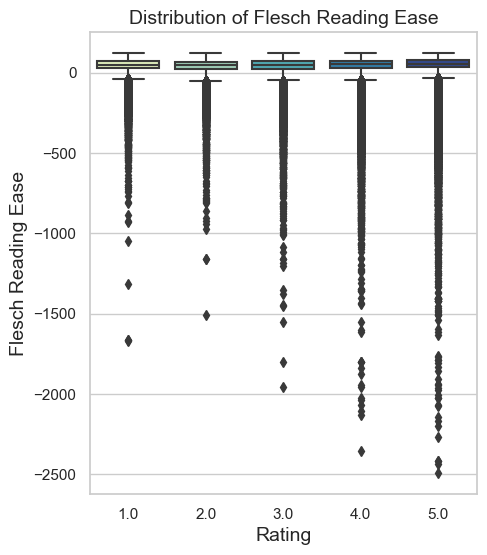

In [169]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5, 6))
palette = "YlGnBu"  
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['flesch_reading_ease'], palette=palette)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Flesch Reading Ease', fontsize=14)
plt.title('Distribution of Flesch Reading Ease', fontsize=14)
plt.show()

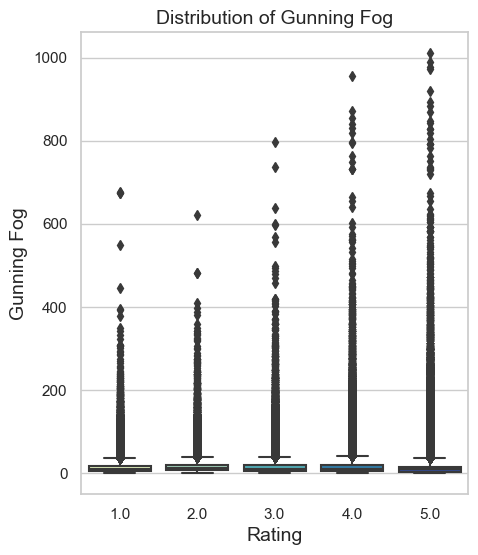

In [83]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5, 6))
palette = "YlGnBu"  
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['gunning_fog'], palette=palette)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Gunning Fog', fontsize=14)
plt.title('Distribution of Gunning Fog', fontsize=14)
plt.show()

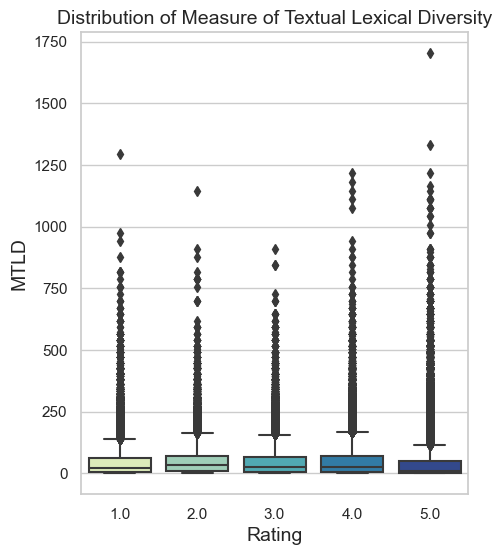

In [84]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5, 6))
palette = "YlGnBu"  
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['measure_of_textual_lexical_diversity'], palette=palette)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('MTLD', fontsize=14)
plt.title('Distribution of Measure of Textual Lexical Diversity', fontsize=14)
plt.show()

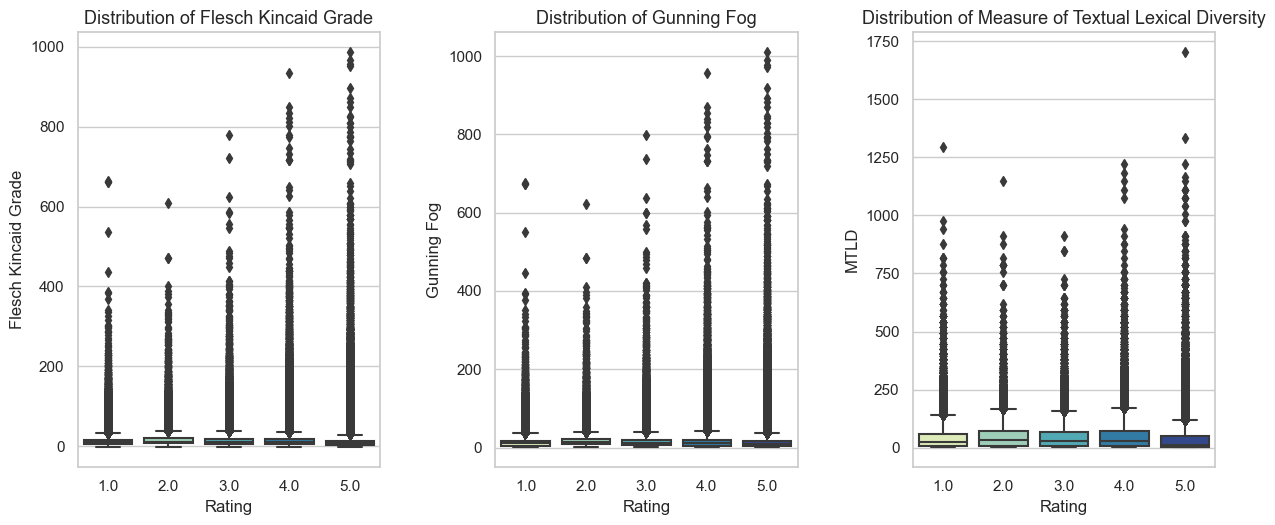

In [81]:
sns.set_theme(style="whitegrid")
palette = "YlGnBu"
plt.figure(figsize=(13, 6))  

# Box plot for Flesch Kincaid Grade
plt.subplot(1, 3, 1)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['flesch_kincaid_grade'], palette=palette)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Flesch Kincaid Grade', fontsize=12)
plt.title('Distribution of Flesch Kincaid Grade', fontsize=13)

# Box plot for Gunning Fog
plt.subplot(1, 3, 2)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['gunning_fog'], palette=palette)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Gunning Fog', fontsize=12)
plt.title('Distribution of Gunning Fog', fontsize=13)

# Box plot for Measure of Textual Lexical Diversity
plt.subplot(1, 3, 3)
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['measure_of_textual_lexical_diversity'], palette=palette)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('MTLD', fontsize=12)
plt.title('Distribution of Measure of Textual Lexical Diversity', fontsize=13)

plt.tight_layout(pad=2.85)
plt.show()

##### no outliers

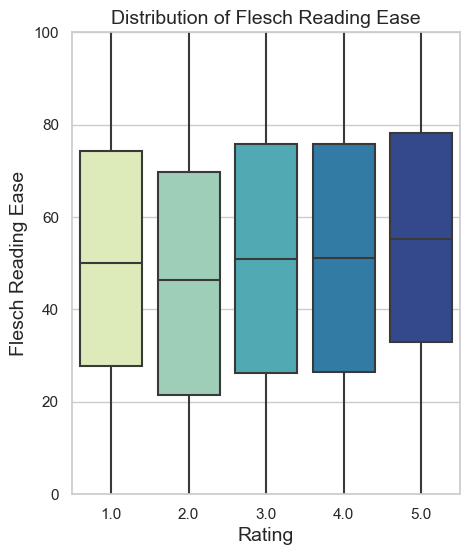

In [176]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5, 6))
palette = "YlGnBu"  
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['flesch_reading_ease'], palette=palette)
plt.ylim(0, 100)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Flesch Reading Ease', fontsize=14)
plt.title('Distribution of Flesch Reading Ease', fontsize=14)
plt.show()

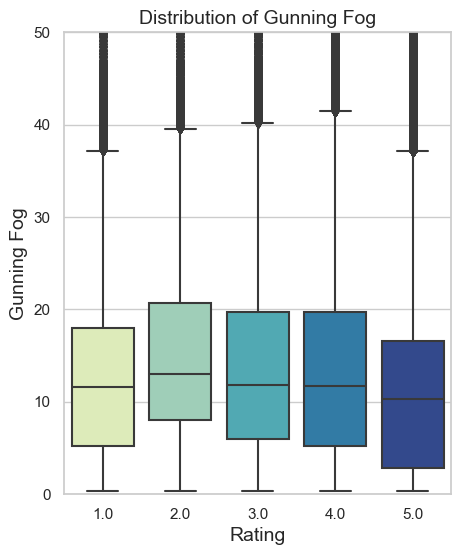

In [97]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5, 6))
palette = "YlGnBu"  
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['gunning_fog'], palette=palette)
plt.ylim(0, 50)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Gunning Fog', fontsize=14)
plt.title('Distribution of Gunning Fog', fontsize=14)
plt.show()

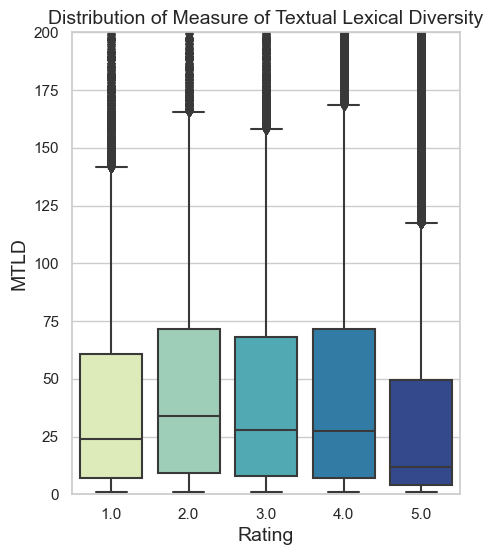

In [100]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5, 6))
palette = "YlGnBu"  
sns.boxplot(x=df_review_norm["overall"], y=df_review_norm['measure_of_textual_lexical_diversity'], palette=palette)
plt.ylim(0, 200)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('MTLD', fontsize=14)
plt.title('Distribution of Measure of Textual Lexical Diversity', fontsize=14)
plt.show()

### Intertemporal Complexity and Diversity

In [213]:
df_review_norm = df_review_norm[df_review_norm['Year'] != 1998]

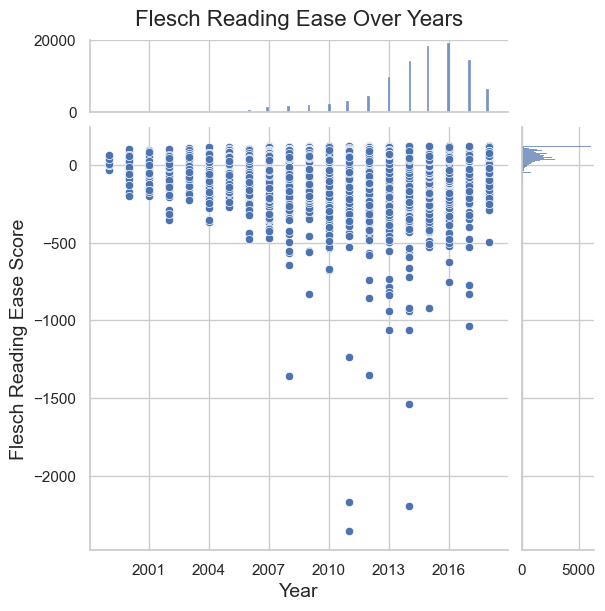

In [227]:
sns.jointplot(data=df_review_norm.sample(100000, random_state=9), x="Year", y="flesch_reading_ease",  marginal_ticks=True)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Flesch Reading Ease Score', fontsize=14)
plt.title('Flesch Reading Ease Over Years', fontsize=16, y=1.22)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

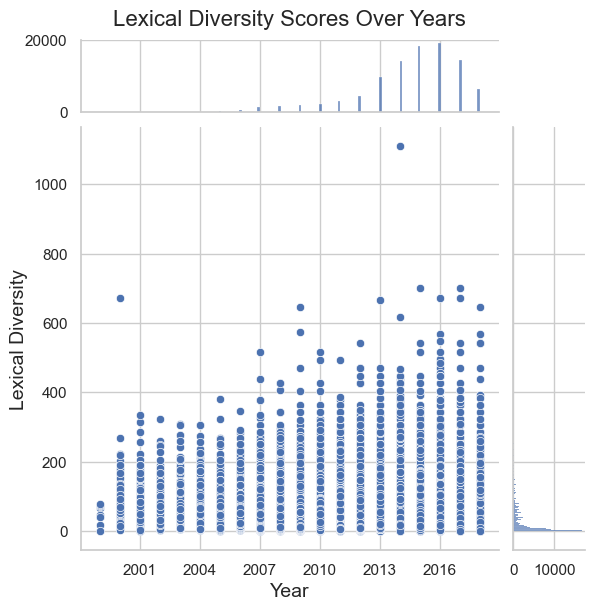

In [228]:
sns.jointplot(data=df_review_norm.sample(100000, random_state=9), x="Year", y="measure_of_textual_lexical_diversity",  marginal_ticks=True)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Lexical Diversity', fontsize=14)
plt.title('Lexical Diversity Scores Over Years', fontsize=16, y=1.22)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

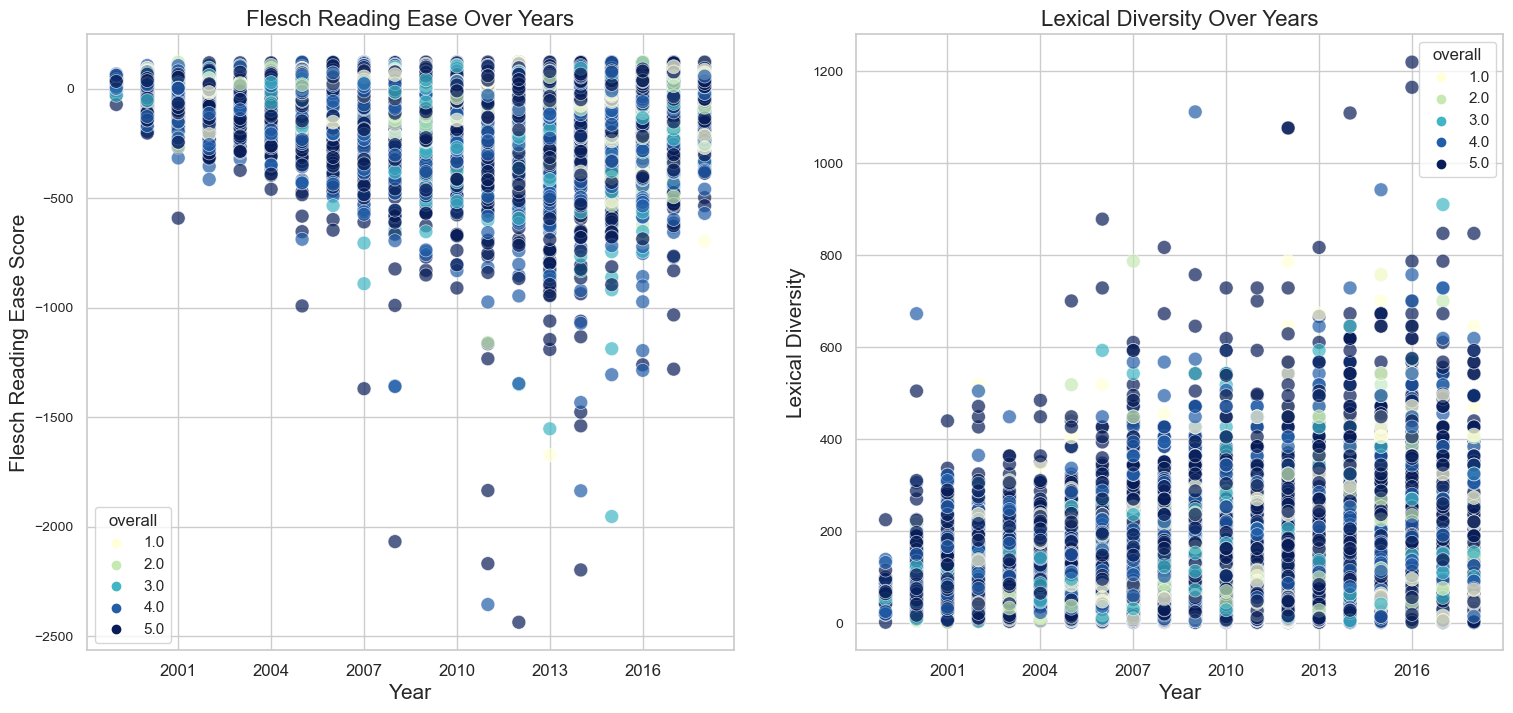

In [229]:
palette = "YlGnBu"
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Year', y='flesch_reading_ease', data=df_review_norm.sample(frac= 0.2, random_state=9), 
                hue="overall", alpha=0.7, edgecolor='w', linewidth=0.5, palette=palette,
                s=100, legend="full")
plt.xlabel('Year', fontsize=15)
plt.ylabel('Flesch Reading Ease Score', fontsize=15)
plt.title('Flesch Reading Ease Over Years', fontsize=16)
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=10) 

plt.subplot(1, 2, 2)
sns.scatterplot(x='Year', y='measure_of_textual_lexical_diversity', data=df_review_norm.sample(frac= 0.2, random_state=9), 
                hue="overall", alpha=0.7, edgecolor='w', linewidth=0.5, palette=palette,
                s=100, legend="full")  
plt.xlabel('Year', fontsize=15)
plt.ylabel('Lexical Diversity', fontsize=15)
plt.title('Lexical Diversity Over Years', fontsize=16)
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=10) 

plt.tight_layout(pad=3.2)
plt.show()


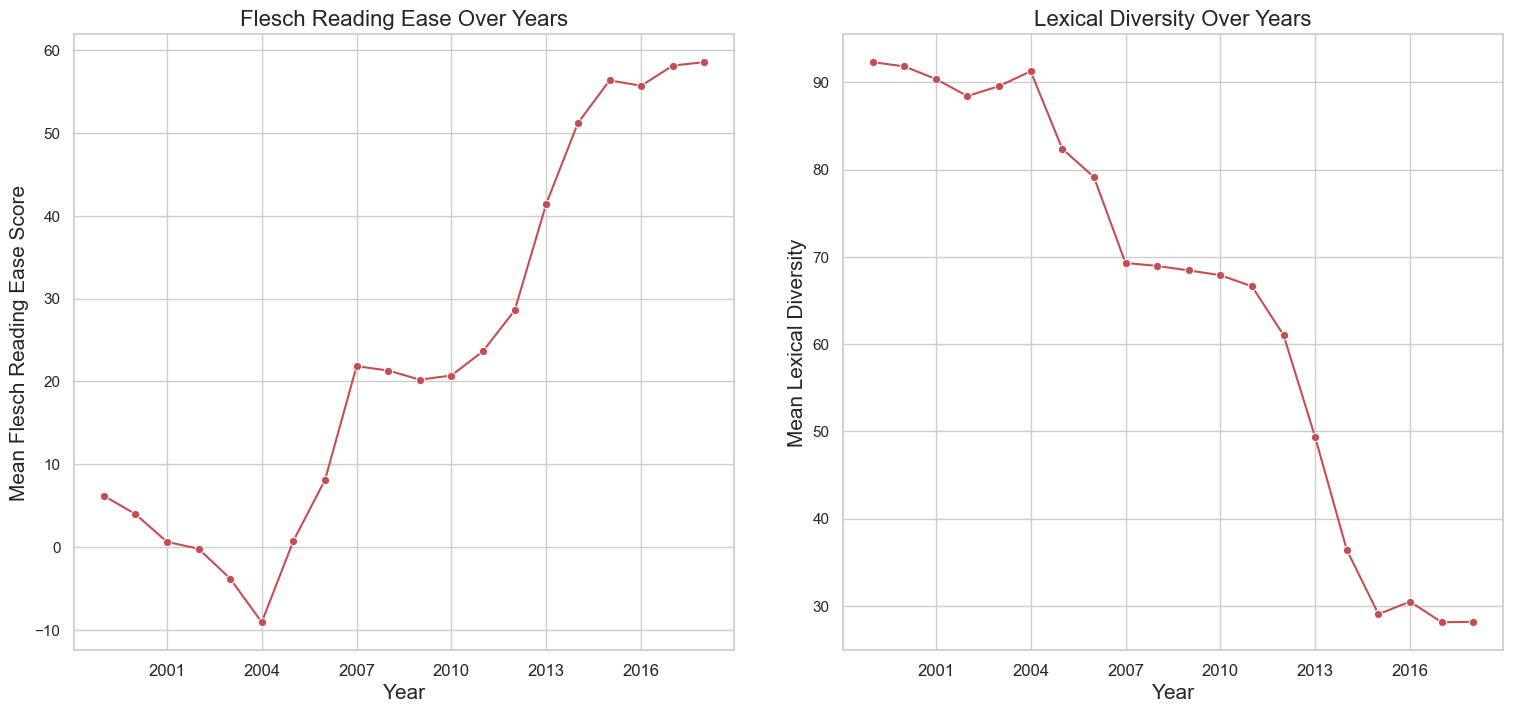

In [230]:
yearly_mean_flesch = df_review_norm.groupby('Year')['flesch_reading_ease'].mean().reset_index()
yearly_mean_lexical = df_review_norm.groupby('Year')['measure_of_textual_lexical_diversity'].mean().reset_index()

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.lineplot(x='Year', y='flesch_reading_ease', data=yearly_mean_flesch, marker='o', color='r')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Mean Flesch Reading Ease Score', fontsize=15)
plt.title('Flesch Reading Ease Over Years', fontsize=16)
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=12)  

plt.subplot(1, 2, 2)
sns.lineplot(x='Year', y='measure_of_textual_lexical_diversity', data=yearly_mean_lexical, marker='o', color='r')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Mean Lexical Diversity', fontsize=15)
plt.title('Lexical Diversity Over Years', fontsize=16)
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=12)  

plt.tight_layout(pad=3.2)
plt.show()


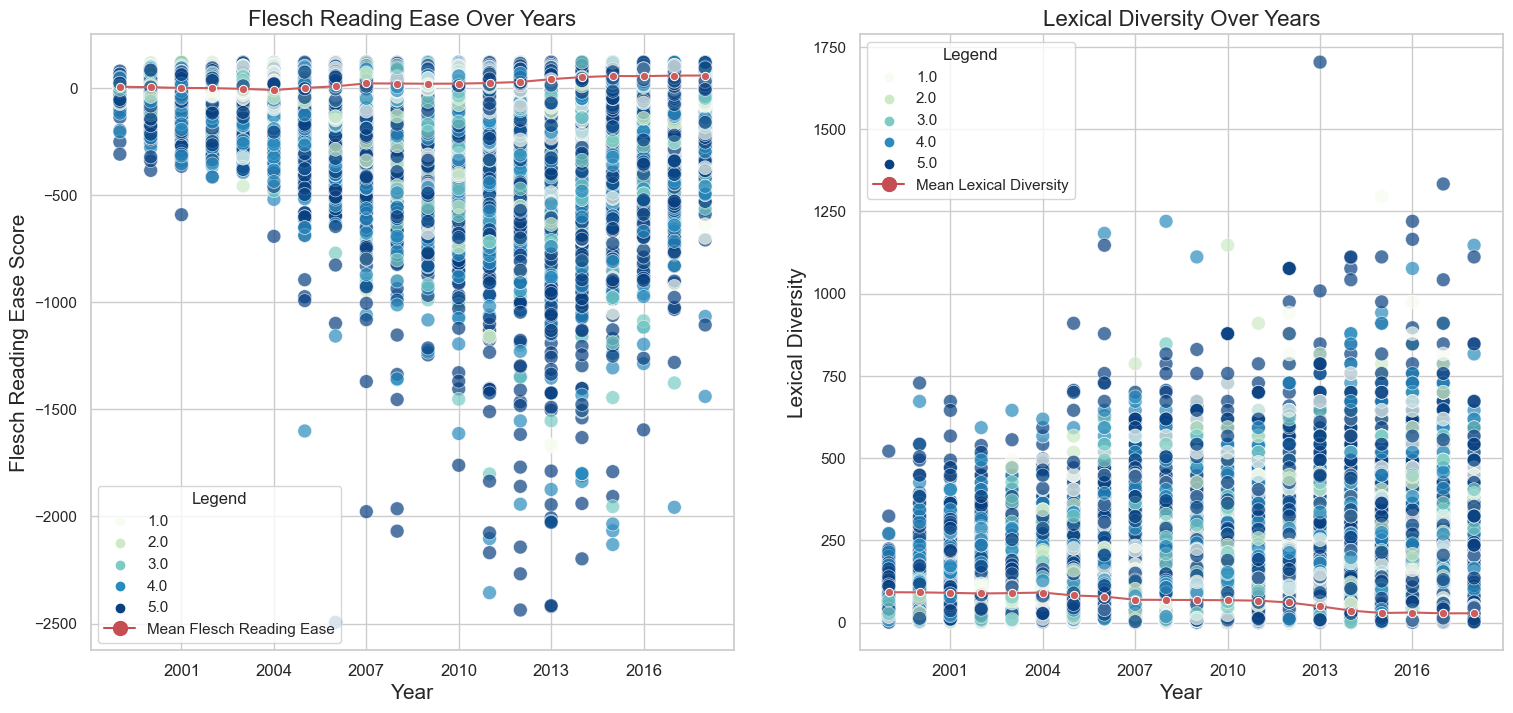

In [231]:
yearly_mean_flesch = df_review_norm.groupby('Year')['flesch_reading_ease'].mean().reset_index()
yearly_mean_lexical = df_review_norm.groupby('Year')['measure_of_textual_lexical_diversity'].mean().reset_index()

palette = "GnBu"
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1) 
scatter = sns.scatterplot(x='Year', y='flesch_reading_ease', data=df_review_norm, 
                          hue="overall", alpha=0.7, edgecolor='w', linewidth=0.5, palette=palette,
                          s=100)
line = sns.lineplot(x='Year', y='flesch_reading_ease', data=yearly_mean_flesch, marker='o', color='indianred')
mean_line = mlines.Line2D([], [], color='r', marker='o', markersize=10, label='Mean Flesch Reading Ease')

plt.xlabel('Year', fontsize=15)
plt.ylabel('Flesch Reading Ease Score', fontsize=15)
plt.title('Flesch Reading Ease Over Years', fontsize=16)
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mean_line) 
plt.legend(handles=handles, title='Legend')
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=12)  

plt.subplot(1, 2, 2)  
scatter = sns.scatterplot(x='Year', y='measure_of_textual_lexical_diversity', data=df_review_norm, 
                          hue="overall", alpha=0.7, edgecolor='w', linewidth=0.5, palette=palette,
                          s=100)
line = sns.lineplot(x='Year', y='measure_of_textual_lexical_diversity', data=yearly_mean_lexical, marker='o', color='indianred')
mean_line_lex = mlines.Line2D([], [], color='r', marker='o', markersize=10, label='Mean Lexical Diversity')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Lexical Diversity', fontsize=15)
plt.title('Lexical Diversity Over Years', fontsize=16)

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mean_line_lex) 
plt.legend(handles=handles, title='Legend')
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=12)  

plt.tight_layout(pad=3.2)
plt.show()


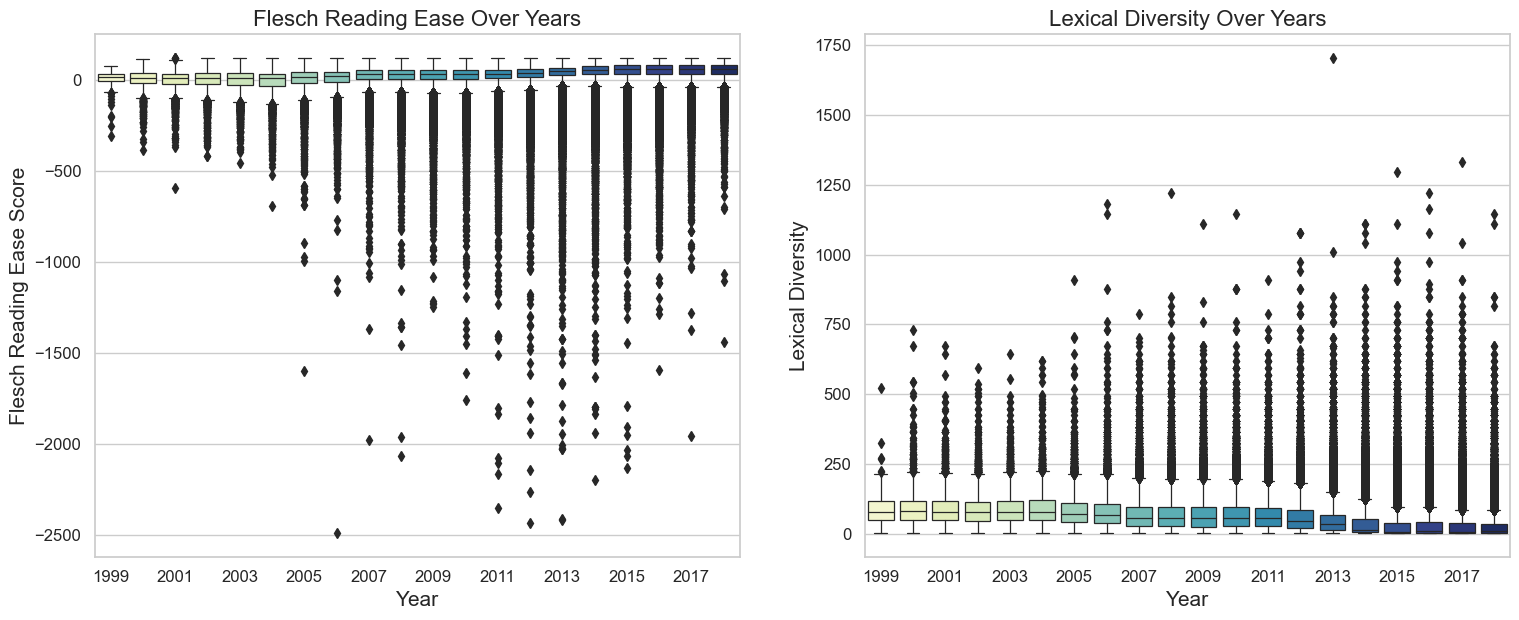

In [247]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 7))
palette="YlGnBu"

# Flesch Reading Ease Over Years
plt.subplot(1, 2, 1)
sns.boxplot(x='Year', y='flesch_reading_ease', data=df_review_norm, palette=palette, linewidth=0.9)    
plt.xlabel('Year', fontsize=15)
plt.ylabel('Flesch Reading Ease Score', fontsize=15)
plt.title('Flesch Reading Ease Over Years', fontsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer ticks
ax = plt.gca()  # Get current axes
ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=12)  

# Lexical Diversity Scores Over Years
plt.subplot(1, 2, 2)
sns.boxplot(x='Year', y='measure_of_textual_lexical_diversity', data=df_review_norm, palette=palette, linewidth=0.9)  
plt.xlabel('Year', fontsize=15)
plt.ylabel('Lexical Diversity', fontsize=15)
plt.title('Lexical Diversity Over Years', fontsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer ticks
ax = plt.gca()  # Get current axes
ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=12)  

plt.tight_layout(pad=3.0)
plt.show()


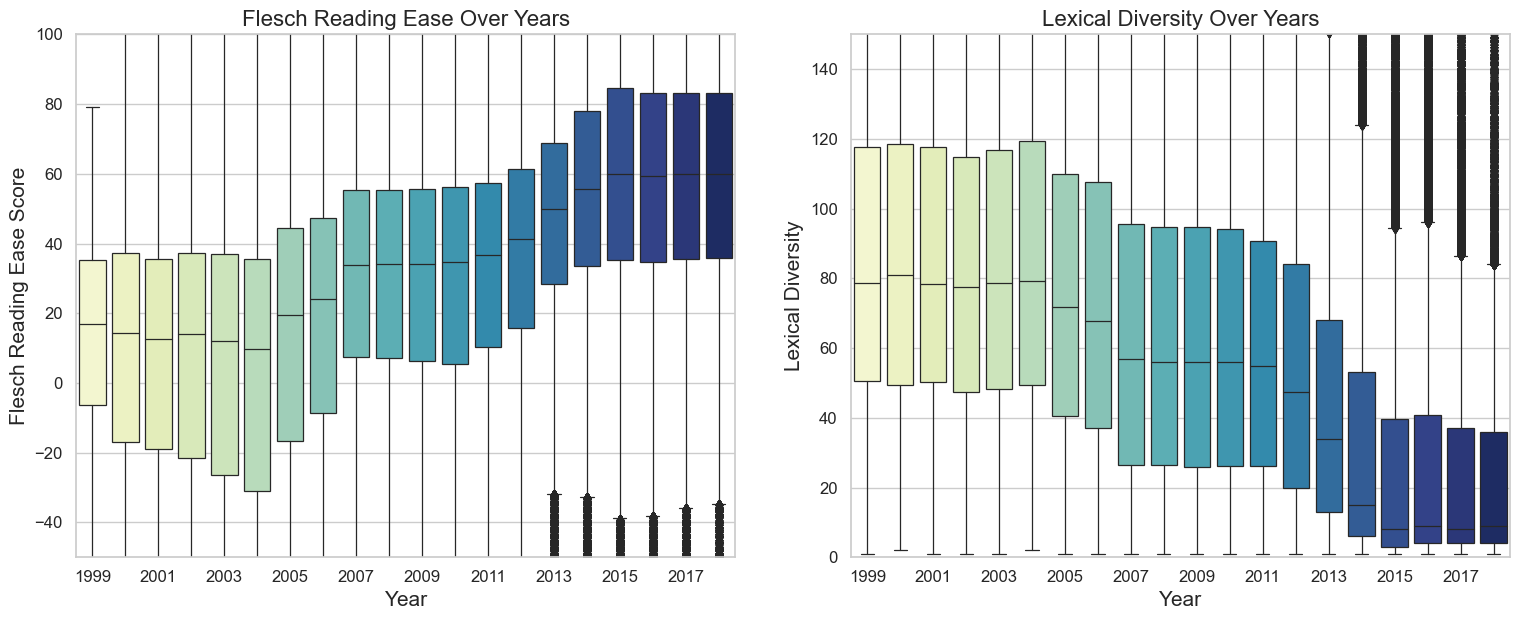

In [246]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 7))
palette="YlGnBu"

# Flesch Reading Ease Over Years
plt.subplot(1, 2, 1)
sns.boxplot(x='Year', y='flesch_reading_ease', data=df_review_norm, palette=palette, linewidth=0.9)  
plt.ylim(-50, 100)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Flesch Reading Ease Score', fontsize=15)
plt.title('Flesch Reading Ease Over Years', fontsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer ticks
ax = plt.gca()  # Get current axes
ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=12)  

# Lexical Diversity Scores Over Years
plt.subplot(1, 2, 2)
sns.boxplot(x='Year', y='measure_of_textual_lexical_diversity', data=df_review_norm, palette=palette, linewidth=0.9)  
plt.ylim(0, 150) 
plt.xlabel('Year', fontsize=15)
plt.ylabel('Lexical Diversity', fontsize=15)
plt.title('Lexical Diversity Over Years', fontsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer ticks
ax = plt.gca()  # Get current axes
ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=12)  

plt.tight_layout(pad=3.0)
plt.show()


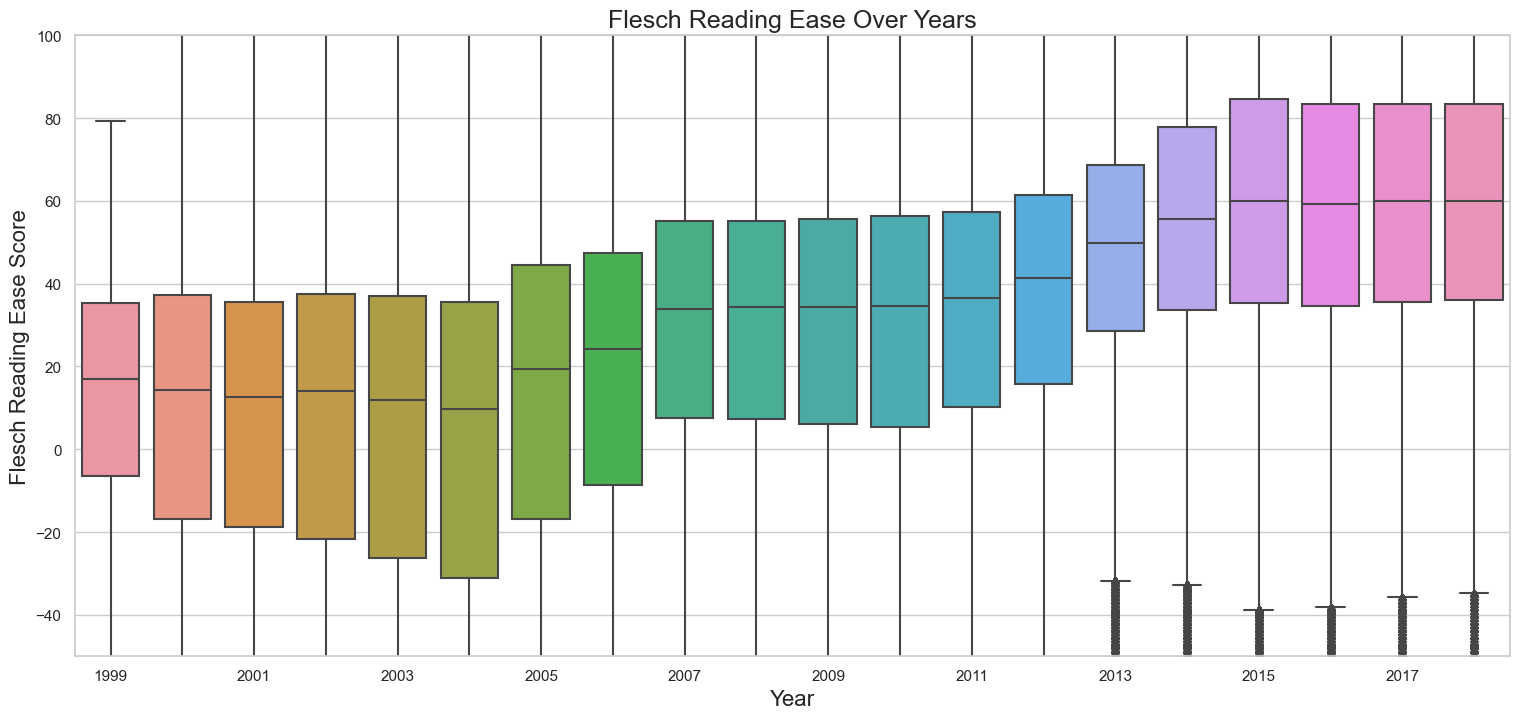

In [234]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

sns.boxplot(x='Year', y='flesch_reading_ease', data=df_review_norm)  
plt.xlabel('Year', fontsize=16)
plt.ylabel('Flesch Reading Ease Score', fontsize=16)
plt.title('Flesch Reading Ease Over Years', fontsize=18)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer ticks
plt.ylim(-50, 100)

plt.tight_layout(pad=3.0)
plt.show()


In [235]:
# also compare to all electronic products
df_review_all_cat_subset_norm['measure_of_textual_lexical_diversity'] = df_review_all_cat_subset_norm['reviewText'].apply(measure_of_textual_lexical_diversity)

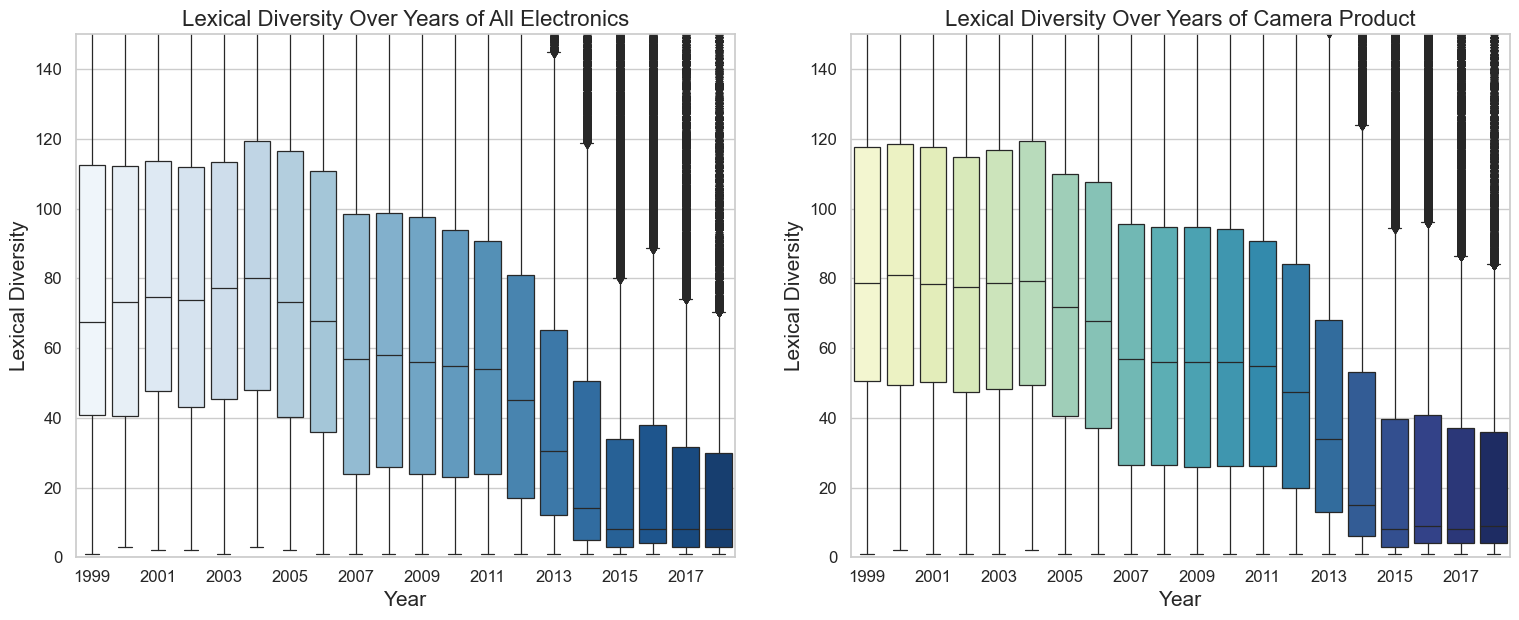

In [245]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.boxplot(x='Year', y='measure_of_textual_lexical_diversity', data=df_review_all_cat_subset_norm, palette="Blues", linewidth=0.9) 
plt.ylim(0, 150) 
plt.xlabel('Year', fontsize=15)
plt.ylabel('Lexical Diversity', fontsize=15)
plt.title('Lexical Diversity Over Years of All Electronics', fontsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer ticks
ax = plt.gca()  # Get current axes
ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=12) 

# Lexical Diversity Scores Over Years
plt.subplot(1, 2, 2)
sns.boxplot(x='Year', y='measure_of_textual_lexical_diversity', data=df_review_norm, palette="YlGnBu", linewidth=0.9) 
plt.ylim(0, 150) 
plt.xlabel('Year', fontsize=15)
plt.ylabel('Lexical Diversity', fontsize=15)
plt.title('Lexical Diversity Over Years of Camera Product', fontsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer ticks
ax = plt.gca()  # Get current axes
ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=12)  

plt.tight_layout(pad=3.0)
plt.show()
